In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, KFold,GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance, plot_tree
import warnings
from matplotlib.pyplot import MultipleLocator
import numpy as np
warnings.filterwarnings('ignore')
import pickle

from time import time
from sklearn.linear_model import Lasso,ElasticNet,ARDRegression

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## rank data 

In [2]:
# #TCGA
# mrna_tcga = pd.read_csv('./data/tcga_breast_mrna.csv', index_col=0)  
# mirna_tcga = pd.read_csv('../PANCancer/pancancer_mirna_sample.csv', index_col=0)  


# # 找到两个文件共同的样本列
# common_samples = list(set(mrna_tcga.columns).intersection(mirna_tcga.columns))

# # 从mrna和mirna数据中筛选共同的样本
# mrna_data_common = mrna_tcga[common_samples]
# mirna_data_common = mirna_tcga[common_samples]

# #删除重复的行索引
# dup_index=mrna_data_common.index.duplicated()
# mrna_data_common=mrna_data_common[~dup_index]
# dup_index=mirna_data_common.index.duplicated()
# mirna_data_common=mirna_data_common[~dup_index]

# # 准备数据
# mrna = mrna_data_common.T  # 转置以匹配样本在行上
# mirna = mirna_data_common.T

# # 对每一行进行排名
# ranked_mirna = mirna.rank(axis=1, ascending=False, method='min')
# ranked_mirna.to_csv('./data/ranked_tcga_breast_mirna.csv')

# ranked_mrna = mrna.rank(axis=1, ascending=False, method='min')
# ranked_mrna.to_csv('./data/ranked_tcga_breast_mrna.csv')

In [3]:
# #CCLE
# mrna_ccle = pd.read_csv('./data/ccle_breast_mrna.csv', index_col=0)  
# mirna_ccle = pd.read_csv('../CCLE/breast_mirna_sample.csv', index_col=0)  


# # 找到两个文件共同的样本列
# common_samples = list(set(mrna_ccle.columns).intersection(mirna_ccle.columns))

# # 从mrna和mirna数据中筛选共同的样本
# mrna_data_common = mrna_ccle[common_samples]
# mirna_data_common = mirna_ccle[common_samples]

# #删除重复的行索引
# dup_index=mrna_data_common.index.duplicated()
# mrna_data_common=mrna_data_common[~dup_index]
# dup_index=mirna_data_common.index.duplicated()
# mirna_data_common=mirna_data_common[~dup_index]

# # 准备数据
# mrna = mrna_data_common.T  # 转置以匹配样本在行上
# mirna = mirna_data_common.T

# # 对每一行进行排名
# ranked_mirna = mirna.rank(axis=1, ascending=False, method='min')
# ranked_mrna = mrna.rank(axis=1, ascending=False, method='min')
# ranked_mrna.to_csv('./data/ranked_ccle_breast_mrna.csv')
# ranked_mirna.to_csv('./data/ranked_ccle_breast_mirna.csv')

## 最大最小标准化

In [4]:
mrna_tcga = pd.read_csv('/kaggle/input/spatial-transcript-data/ranked_tcga_breast_mrna.csv', index_col=0)  
mirna_tcga = pd.read_csv('/kaggle/input/spatial-transcript-data/ranked_tcga_breast_mirna.csv', index_col=0)  

In [5]:
# 使用 StandardScaler 进行 z-score 标准化
scaler1 = MinMaxScaler()
mrna_scale = scaler1.fit_transform(mrna_tcga)

# # 使用 StandardScaler 进行 z-score 标准化
scaler2 = MinMaxScaler()
mirna_scale = scaler2.fit_transform(mirna_tcga)

mrna_tcga = pd.DataFrame(mrna_scale, columns=mrna_tcga.columns)
mirna_tcga = pd.DataFrame(mirna_scale, columns=mirna_tcga.columns)

In [6]:
mirna_tcga.shape,mrna_tcga.shape

((1162, 743), (1162, 1773))

In [7]:
x_train, x_test, y_train, y_test = train_test_split(mrna_tcga, mirna_tcga,test_size=0.1)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1045, 1773), (117, 1773), (1045, 743), (117, 743))

## build model on tcga breast

In [8]:
other_params = {'learning_rate': 0.05, 'n_estimators': 150, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

# 建立XGBoost模型 
model = XGBRegressor(**other_params,tree_method="hist", device="cuda")

t0 = time()
# 训练模型
model.fit(x_train, y_train)
print(f"XGBoost fit done in {(time() - t0):.3f}s")

# 使用模型进行预测
predictions = model.predict(x_test)
r2_score_xgb = r2_score(y_test, predictions)
print(f"XGBoost r^2 on test data : {r2_score_xgb:.3f}")

XGBoost fit done in 489.785s
XGBoost r^2 on test data : 0.190


In [9]:
#保存Model(注:save文件夹要预先建立，否则会报错)
with open('clf_bulk.pickle', 'wb') as f:
    pickle.dump(model, f)
 
#读取Model
with open('clf_bulk.pickle', 'rb') as f:
    clf = pickle.load(f)
    #测试读取后的Model
    predictions = clf.predict(x_test)    

In [10]:
t0 = time()
lasso = Lasso(alpha=0.02).fit(x_train, y_train)
print(f"Lasso fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso.predict(x_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso r^2 on test data : {r2_score_lasso:.3f}\n")

t0 = time()
enet = ElasticNet(alpha=0.08, l1_ratio=0.1).fit(x_train, y_train)
print(f"ElasticNet fit done in {(time() - t0):.3f}s")

y_pred_enet = enet.predict(x_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(f"ElasticNet r^2 on test data : {r2_score_enet:.3f}")

Lasso fit done in 11.590s
Lasso r^2 on test data : 0.011

ElasticNet fit done in 17.287s
ElasticNet r^2 on test data : 0.078


In [11]:
def metrics_sklearn(y_valid, y_pred_):
    """模型对验证集和测试集结果的评分"""

    mse = mean_squared_error(y_valid, y_pred_)
    print('mse：%f' % mse)

    mae = mean_absolute_error(y_valid, y_pred_)
    print('mae：%f' % mae )

    r2 = r2_score(y_valid, y_pred_)
    print('r2：%f' % r2)
    
    R2 = r2_score(y_valid.values.flatten(),y_pred_.flatten())
    print('r2：%f\n' % R2)

In [12]:
metrics_sklearn(y_test,predictions)
metrics_sklearn(y_test,y_pred_lasso)
metrics_sklearn(y_test,y_pred_enet)

mse：0.025300
mae：0.109243
r2：0.190496
r2：0.741753

mse：0.030233
mae：0.124615
r2：0.010895
r2：0.691402

mse：0.028125
mae：0.119404
r2：0.077546
r2：0.712918



In [13]:
y_ = model.predict(x_train)
metrics_sklearn(y_train,y_)

mse：0.001289
mae：0.025725
r2：0.951818
r2：0.986752



0.7417531094128591


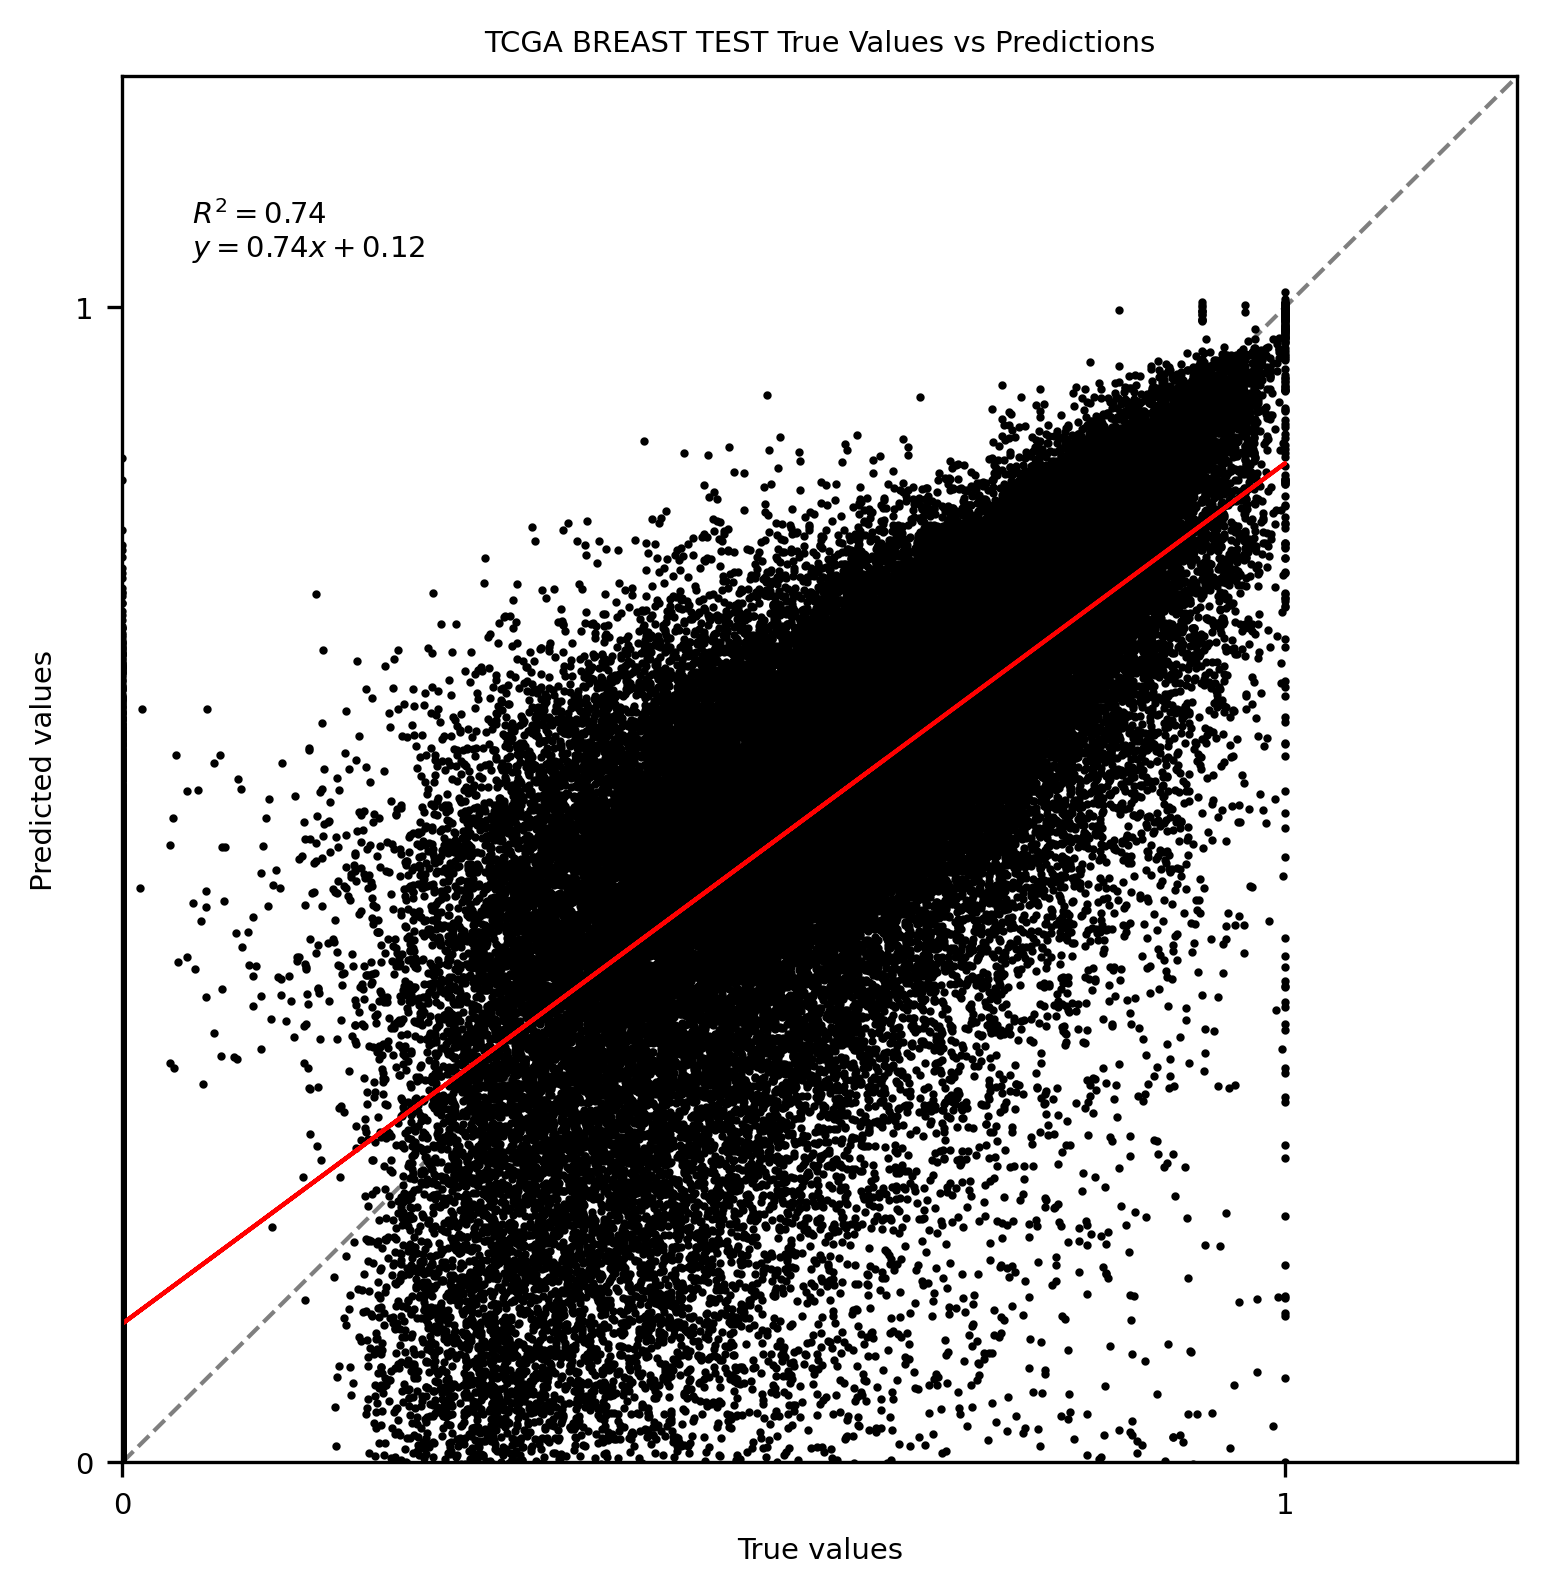

In [14]:
"""
输出观测值和模型预测值之间的拟合曲线,即拟合模型
决定系数R2，有拟合曲线公式，有1:1线
注意：R2、RMSE是预测和实测计算的，即原来的反演或预测模型的值。拟合曲线模型是预测和实测重新计算的拟合曲线。点代表每一个元素值
"""

# x: 是观测值; y: 是模型预测值
x = y_test.values.flatten()
y=predictions.flatten()

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
# 绘制1:1对角线，linewidth线的粗细，ls线的格式，c线的颜色，
ax.plot((0, 1), (0, 1), linewidth=1, transform=ax.transAxes, ls='--', c='k', label="1:1 line", alpha=0.5)
# 绘制点，'o'点的形状，点的颜色，markersize点的大小
ax.plot(x, y, 'o', c='black', markersize=1)

# polyfit(x, y, 1)，1代表线性拟合
# parameter返回的是线性拟合线的斜率和截距
parameter = np.polyfit(x, y, 1)
f = np.poly1d(parameter)
ax.plot(x, f(x), 'r-', lw=1)

# 计算决定系数R
r2 = r2_score(x,y)
print(r2)

# 那个框框的设置
bbox = dict(boxstyle="round", fc='1', alpha=0.)
bbox = bbox
# 在图上安放R2和拟合曲线公式，0.05和0.87是位置偏移量，自己调试
plt.text(0.05, 0.87, "$R^2=%.2f$\n$y=%.2fx+%.2f$" % ((r2), parameter[0], parameter[1]),
         transform=ax.transAxes, size=7, bbox=bbox)

# 横轴的设置
ax.set_xlabel('True values', fontsize=7)
ax.set_ylabel("Predicted values", fontsize=7)

# 设置图片title
ax.tick_params(labelsize=7)
ax.set_title("TCGA BREAST TEST True Values vs Predictions", fontsize=7)

x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
y_major_locator = MultipleLocator(1)
ax.yaxis.set_major_locator(y_major_locator)
# 坐标轴
ax.set(xlim=(0, 1.2), ylim=(0,1.2))

plt.savefig("TCGA BREAST TEST True vs Pre.jpg")
plt.show()

0.986752152376226


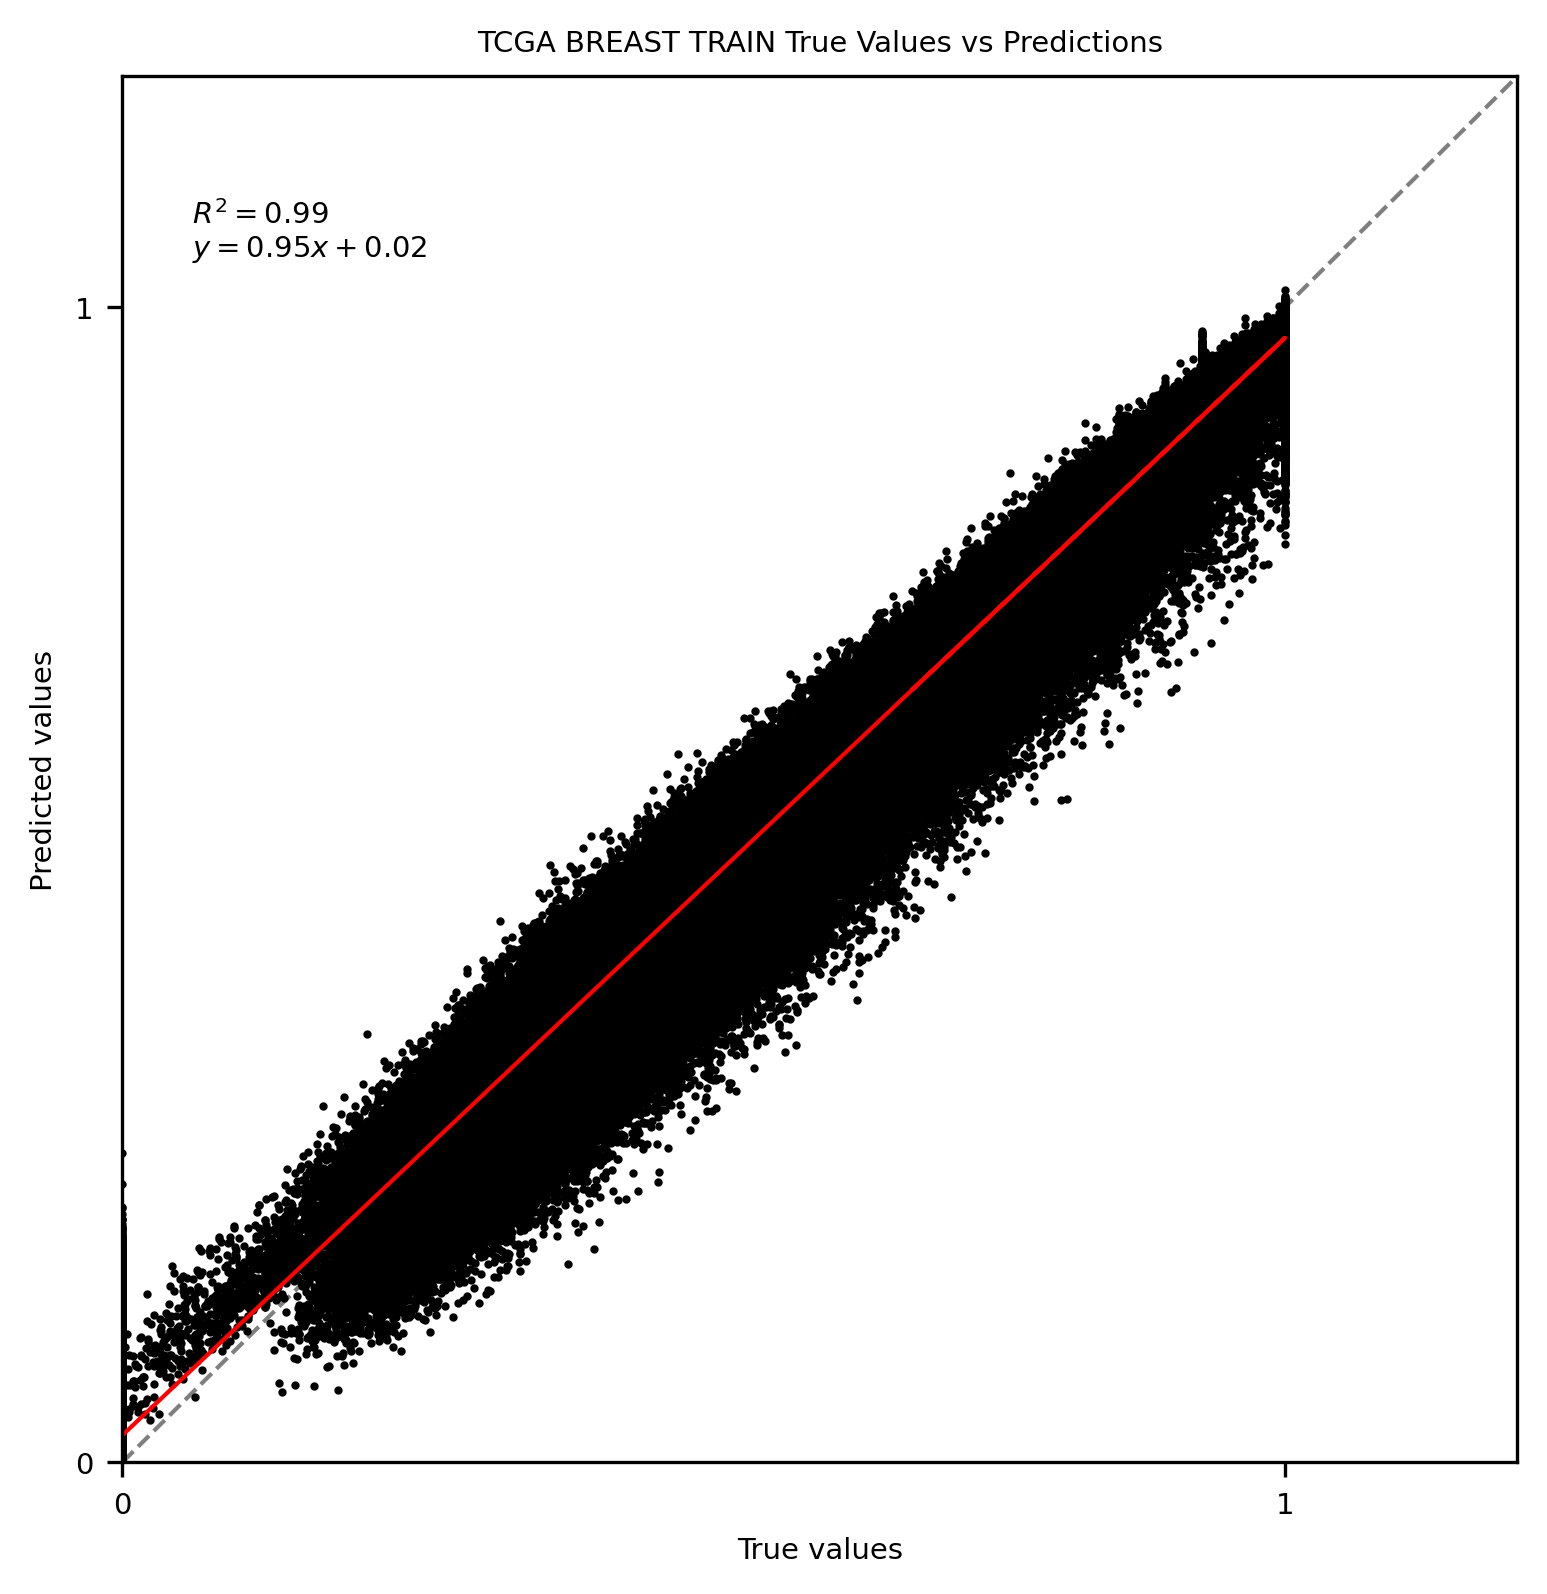

In [15]:
"""
输出观测值和模型预测值之间的拟合曲线,即拟合模型
决定系数R2，有拟合曲线公式，有1:1线
注意：R2、RMSE是预测和实测计算的，即原来的反演或预测模型的值。拟合曲线模型是预测和实测重新计算的拟合曲线。点代表每一个元素值
"""

# x: 是观测值; y: 是模型预测值
x = y_train.values.flatten()
y=y_.flatten()

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
# 绘制1:1对角线，linewidth线的粗细，ls线的格式，c线的颜色，
ax.plot((0, 1), (0, 1), linewidth=1, transform=ax.transAxes, ls='--', c='k', label="1:1 line", alpha=0.5)
# 绘制点，'o'点的形状，点的颜色，markersize点的大小
ax.plot(x, y, 'o', c='black', markersize=1)

# polyfit(x, y, 1)，1代表线性拟合
# parameter返回的是线性拟合线的斜率和截距
parameter = np.polyfit(x, y, 1)
f = np.poly1d(parameter)
ax.plot(x, f(x), 'r-', lw=1)

# 计算决定系数R
r2 = r2_score(x,y)
print(r2)

# 那个框框的设置
bbox = dict(boxstyle="round", fc='1', alpha=0.)
bbox = bbox
# 在图上安放R2和拟合曲线公式，0.05和0.87是位置偏移量，自己调试
plt.text(0.05, 0.87, "$R^2=%.2f$\n$y=%.2fx+%.2f$" % ((r2), parameter[0], parameter[1]),
         transform=ax.transAxes, size=7, bbox=bbox)

# 横轴的设置
ax.set_xlabel('True values', fontsize=7)
ax.set_ylabel("Predicted values", fontsize=7)

# 设置图片title
ax.tick_params(labelsize=7)
ax.set_title("TCGA BREAST TRAIN True Values vs Predictions", fontsize=7)

x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
y_major_locator = MultipleLocator(1)
ax.yaxis.set_major_locator(y_major_locator)
# 坐标轴
ax.set(xlim=(0, 1.2), ylim=(0,1.2))

plt.savefig("TCGA BREAST TRAIN True vs Pre.jpg")
plt.show()

### 预测spatial mirna

In [16]:
tcga_st_mrna = pd.read_csv("/kaggle/input/spatial-transcript-data/st_exp.csv",index_col=0)
tcga_st_mrna = tcga_st_mrna.T

In [17]:
tcga_st_mirna = clf.predict(tcga_st_mrna)

In [18]:
tcga_st_mirna = pd.DataFrame(tcga_st_mirna,index=tcga_st_mrna.index,columns=y_train.columns)
tcga_st_mirna.to_csv("Pretcga-STmirna.csv")

In [19]:
tcga_st_mirna.describe()

,hsa-let-7a-2-3p,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-3p,hsa-let-7c-5p,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-3p,...,hsa-miR-527,hsa-miR-548x-3p,hsa-miR-5584-5p,hsa-miR-670-3p,hsa-miR-885-3p,hsa-miR-888-5p,hsa-miR-890,hsa-miR-891b,hsa-miR-892b,hsa-miR-892c-3p
count,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,...,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000
mean,0.372020,0.525412,0.517267,0.510317,0.517477,0.454474,0.390463,0.526964,0.434308,0.439719,...,0.693040,0.731628,0.920775,0.476814,0.953879,0.764168,0.000216,0.617440,0.664713,0.449514
std,0.067288,0.046519,0.035071,0.029762,0.035409,0.062117,0.059727,0.029692,0.036777,0.038880,...,0.062947,0.075122,0.068776,0.079060,0.084828,0.083508,0.000000,0.107785,0.104418,0.166688
min,0.184698,0.345824,0.406164,0.412010,0.409074,0.306362,0.221640,0.424430,0.312599,0.318141,...,0.421618,0.490035,0.674541,0.230497,0.650773,0.489179,0.000216,0.392977,0.425525,0.166135
25%,0.320088,0.492914,0.494006,0.489680,0.492528,0.404222,0.348854,0.506352,0.408701,0.414141,...,0.651685,0.679557,0.877734,0.421434,0.898750,0.706363,0.000216,0.541452,0.587117,0.330660
50%,0.373143,0.529032,0.517297,0.510221,0.516502,0.450173,0.382503,0.525483,0.433470,0.438769,...,0.692394,0.729089,0.920184,0.475243,0.955651,0.759923,0.000216,0.591954,0.641243,0.395549
75%,0.419069,0.561304,0.540030,0.529531,0.540775,0.500307,0.432300,0.546477,0.460043,0.466056,...,0.733842,0.777774,0.963216,0.523973,1.012983,0.820604,0.000216,0.669064,0.720685,0.526129
max,0.561123,0.653031,0.646034,0.610689,0.643977,0.650879,0.609205,0.631718,0.572303,0.571386,...,0.897742,1.094453,1.167571,0.755133,1.190548,1.054973,0.000216,0.974780,1.021053,0.991518


In [20]:
y_train.describe()

,hsa-let-7a-2-3p,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-3p,hsa-let-7c-5p,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-3p,...,hsa-miR-527,hsa-miR-548x-3p,hsa-miR-5584-5p,hsa-miR-670-3p,hsa-miR-885-3p,hsa-miR-888-5p,hsa-miR-890,hsa-miR-891b,hsa-miR-892b,hsa-miR-892c-3p
count,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,...,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.0,1045.000000,1045.000000,1045.000000
mean,0.681736,0.709364,0.619474,0.663139,0.685933,0.814666,0.648055,0.624296,0.581056,0.704971,...,0.057108,0.020266,0.031723,0.004845,0.030504,0.017403,0.0,0.013123,0.007213,0.003332
std,0.146474,0.095684,0.156779,0.126541,0.149879,0.100105,0.150969,0.129220,0.135345,0.117210,...,0.143691,0.108595,0.137174,0.052341,0.134432,0.093063,0.0,0.071163,0.063978,0.044788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206107,0.009259,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.615260,0.649351,0.500000,0.596026,0.600000,0.766055,0.584158,0.541985,0.490741,0.652568,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.706169,0.717532,0.600000,0.675497,0.700000,0.828746,0.673267,0.633588,0.592593,0.722054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.779221,0.772727,0.750000,0.751656,0.800000,0.882263,0.742574,0.709924,0.675926,0.779456,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.954392,1.000000,1.000000,0.877384,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


## build model on ccle breast

In [21]:
# 读取breast cancer mrna和mirna数据
mrna_ccle = pd.read_csv('/kaggle/input/spatial-transcript-data/ranked_ccle_breast_mrna.csv', index_col=0)  # 假设mrna文件的行名为基因
mirna_ccle = pd.read_csv('/kaggle/input/spatial-transcript-data/ranked_ccle_breast_mirna.csv', index_col=0)  # 假设mirna文件的行名为mirna

In [22]:
# 使用 StandardScaler 进行 z-score 标准化
scaler1 = MinMaxScaler()
mrna_scale = scaler1.fit_transform(mrna_ccle)

# # 使用 StandardScaler 进行 z-score 标准化
scaler2 = MinMaxScaler()
mirna_scale = scaler2.fit_transform(mirna_ccle)

mrna_ccle = pd.DataFrame(mrna_scale, columns=mrna_ccle.columns)
mirna_ccle = pd.DataFrame(mirna_scale, columns=mirna_ccle.columns)

In [23]:
mrna_ccle.shape,mirna_ccle.shape

((50, 1773), (50, 734))

In [24]:
x_train, x_test, y_train, y_test = train_test_split(mrna_ccle, mirna_ccle,test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((40, 1773), (10, 1773), (40, 734), (10, 734))

In [25]:
from sklearn.model_selection import cross_val_score
other_params = {'learning_rate': 0.05, 'n_estimators': 150, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

# 建立XGBoost模型 
model = XGBRegressor(**other_params,tree_method="hist", device="cuda")

t0 = time()
# 训练模型
model.fit(x_train, y_train)
print(f"XGBoost fit done in {(time() - t0):.3f}s")

# 使用模型进行预测
predictions = model.predict(x_test)
r2_score_xgb = r2_score(y_test, predictions)
print(f"XGBoost r^2 on test data : {r2_score_xgb:.3f}")

t0 = time()
scores = cross_val_score(model, x_train, y_train, cv=5,scoring='neg_mean_squared_error')
print(f"XGBoost fit done in {(time() - t0):.3f}s")
print("MSE scores:\n", scores)

XGBoost fit done in 143.211s
XGBoost r^2 on test data : -0.221
XGBoost fit done in 625.515s
MSE scores:
 [-0.05190207 -0.05452929 -0.0570254  -0.0661361  -0.05864595]


In [26]:
#保存Model(注:save文件夹要预先建立，否则会报错)
# with open('save_model/clf_ccle_bulk.pickle', 'wb') as f:
#     pickle.dump(model, f)
 
#读取Model
# with open('save_model/clf_ccle_bulk.pickle', 'rb') as f:
#     clf = pickle.load(f)
#     #测试读取后的Model
#     predictions = clf.predict(mrna)    

In [27]:
t0 = time()
lasso = Lasso(alpha=0.05).fit(x_train, y_train)
print(f"Lasso fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso.predict(x_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso r^2 on test data : {r2_score_lasso:.3f}\n")

t0 = time()
enet = ElasticNet(alpha=0.1, l1_ratio=0.1).fit(x_train, y_train)
print(f"ElasticNet fit done in {(time() - t0):.3f}s")

y_pred_enet = enet.predict(x_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(f"ElasticNet r^2 on test data : {r2_score_enet:.3f}")

Lasso fit done in 0.889s
Lasso r^2 on test data : -0.160

ElasticNet fit done in 4.647s
ElasticNet r^2 on test data : -0.165


In [28]:
y_=model.predict(x_train)

In [29]:
metrics_sklearn(y_test,predictions)
metrics_sklearn(y_test,y_pred_lasso)
metrics_sklearn(y_test,y_pred_enet)
metrics_sklearn(y_train,y_)

mse：0.056597
mae：0.184620
r2：-0.221500
r2：0.330156

mse：0.056253
mae：0.184533
r2：-0.159941
r2：0.334227

mse：0.055414
mae：0.182055
r2：-0.165292
r2：0.344161

mse：0.000207
mae：0.007465
r2：0.994400
r2：0.997554



0.3301562329744455


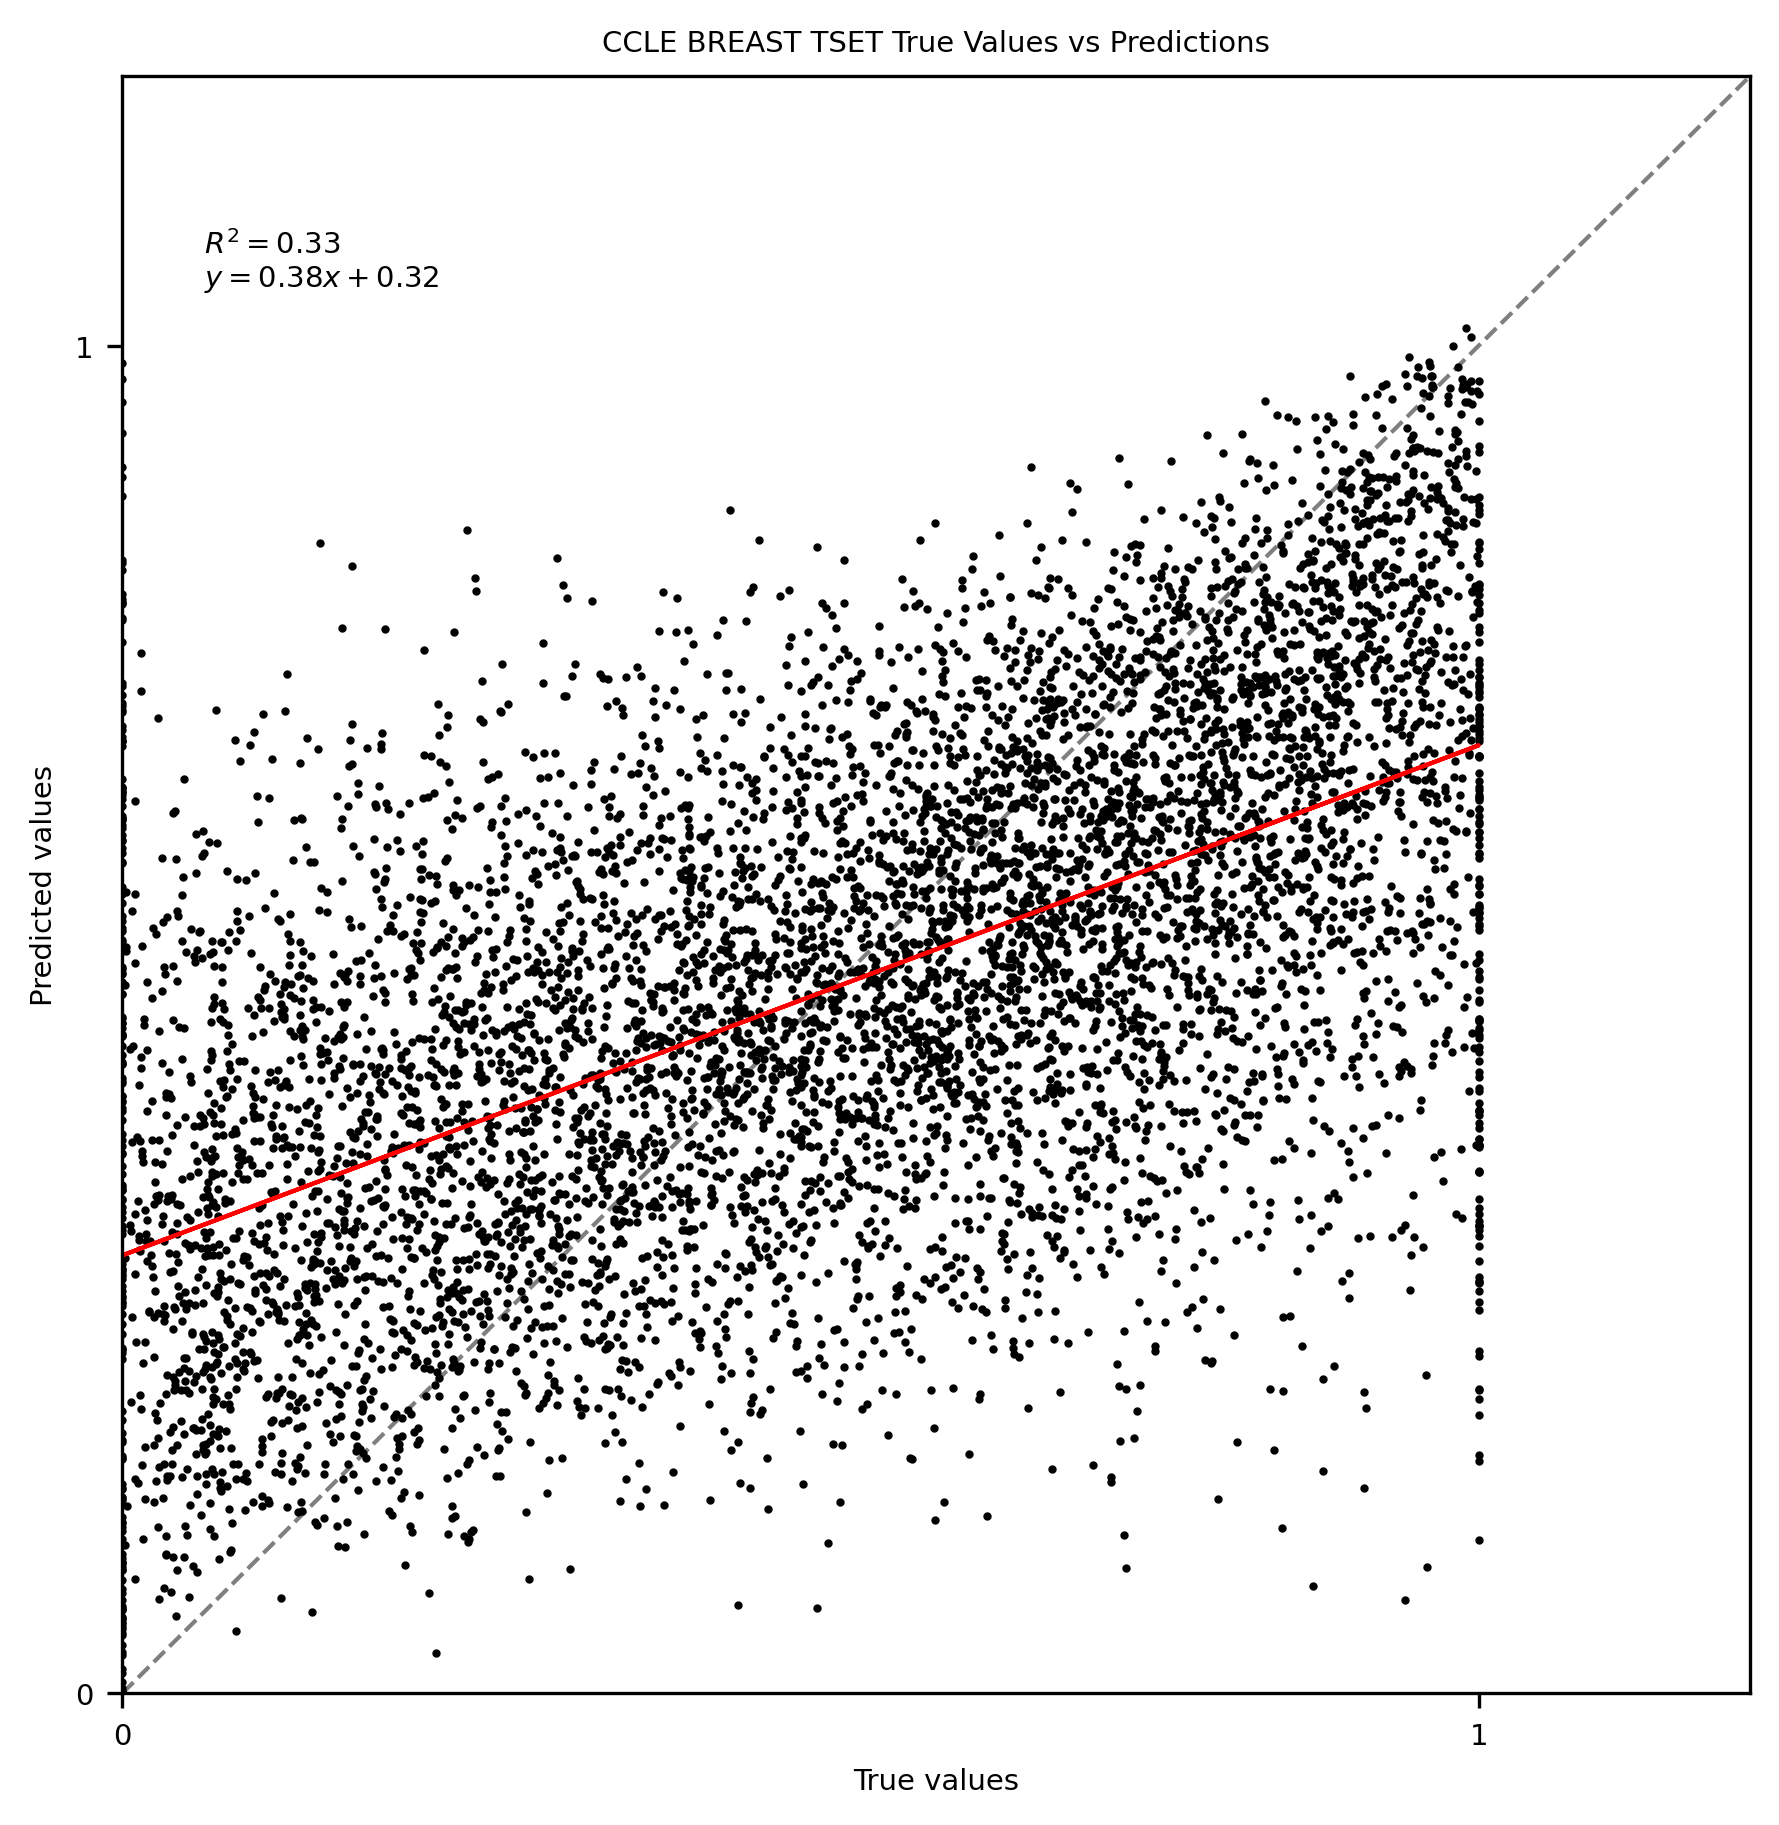

In [30]:
"""
输出观测值和模型预测值之间的拟合曲线,即拟合模型
决定系数R2，有拟合曲线公式，有1:1线
注意：R2、RMSE是预测和实测计算的，即原来的反演或预测模型的值。拟合曲线模型是预测和实测重新计算的拟合曲线。
"""
# x: 是观测值; y: 是模型预测值
x = y_test.values.flatten()
y=predictions.flatten()

fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
# 绘制1:1对角线，linewidth线的粗细，ls线的格式，c线的颜色，
ax.plot((0, 1), (0, 1), linewidth=1, transform=ax.transAxes, ls='--', c='k', label="1:1 line", alpha=0.5)
# 绘制点，'o'点的形状，点的颜色，markersize点的大小
ax.plot(x, y, 'o', c='black', markersize=1)

# polyfit(x, y, 1)，1代表线性拟合
# parameter返回的是线性拟合线的斜率和截距
parameter = np.polyfit(x, y, 1)
f = np.poly1d(parameter)
ax.plot(x, f(x), 'r-', lw=1)

# 计算决定系数R
r2 = r2_score(x,y)
print(r2)

# 那个框框的设置
bbox = dict(boxstyle="round", fc='1', alpha=0.)
bbox = bbox
# 在图上安放R2和拟合曲线公式，0.05和0.87是位置偏移量，自己调试
plt.text(0.05, 0.87, "$R^2=%.2f$\n$y=%.2fx+%.2f$" % ((r2), parameter[0], parameter[1]),
         transform=ax.transAxes, size=7, bbox=bbox)

# 横轴的设置
ax.set_xlabel('True values', fontsize=7)
ax.set_ylabel("Predicted values", fontsize=7)

# 设置图片title
ax.tick_params(labelsize=7)
ax.set_title("CCLE BREAST TSET True Values vs Predictions", fontsize=7)

x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
y_major_locator = MultipleLocator(1)
ax.yaxis.set_major_locator(y_major_locator)
# 坐标轴
ax.set(xlim=(0, 1.2), ylim=(0,1.2))

plt.savefig("CCLE BREAST TEST True vs Pre.jpg")
plt.show()

0.9975540338064177


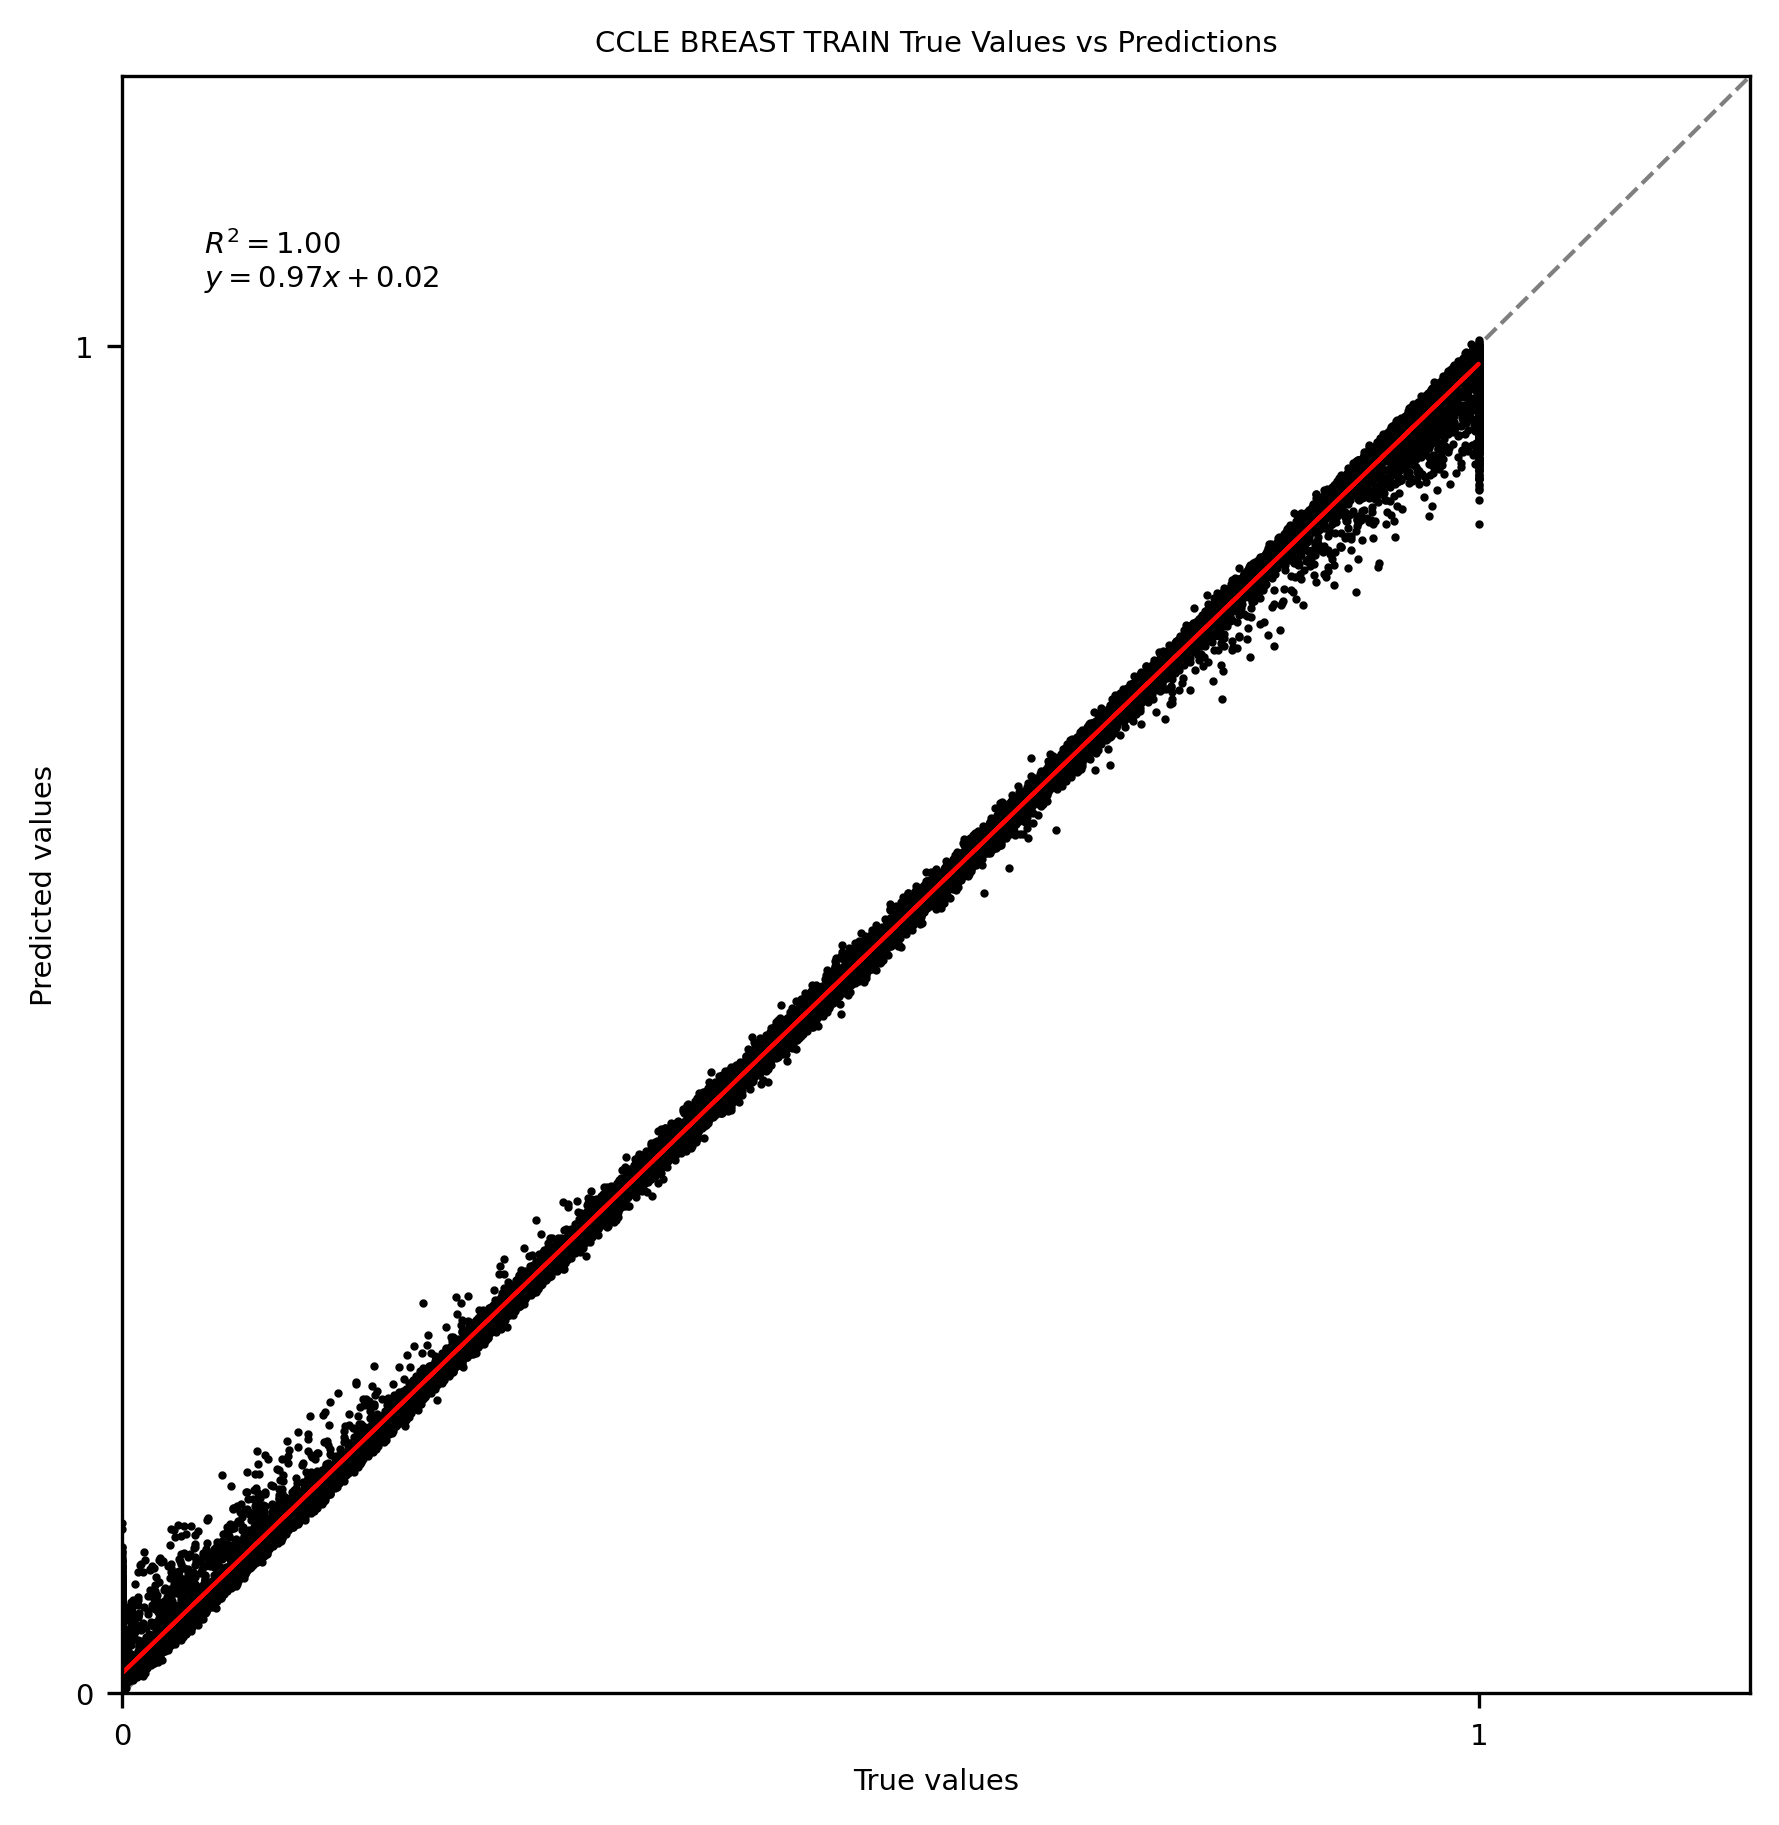

In [31]:
"""
输出观测值和模型预测值之间的拟合曲线,即拟合模型
决定系数R2，有拟合曲线公式，有1:1线
注意：R2、RMSE是预测和实测计算的，即原来的反演或预测模型的值。拟合曲线模型是预测和实测重新计算的拟合曲线。
"""
# R2计算
def R2(target, predict):
    SSE = sum((target - predict) ** 2)
    SST = sum((target - (target).mean()) ** 2)
    return 1 - (SSE / SST)

# x: 是观测值; y: 是模型预测值
x = y_train.values.flatten()
y = y_.flatten()

fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
# 绘制1:1对角线，linewidth线的粗细，ls线的格式，c线的颜色，
ax.plot((0, 1), (0, 1), linewidth=1, transform=ax.transAxes, ls='--', c='k', label="1:1 line", alpha=0.5)
# 绘制点，'o'点的形状，点的颜色，markersize点的大小
ax.plot(x, y, 'o', c='black', markersize=1)

# polyfit(x, y, 1)，1代表线性拟合
# parameter返回的是线性拟合线的斜率和截距
parameter = np.polyfit(x, y, 1)
f = np.poly1d(parameter)
ax.plot(x, f(x), 'r-', lw=1)

# 计算决定系数R
r2 = r2_score(x,y)
print(r2)

# 那个框框的设置
bbox = dict(boxstyle="round", fc='1', alpha=0.)
bbox = bbox
# 在图上安放R2和拟合曲线公式，0.05和0.87是位置偏移量，自己调试
plt.text(0.05, 0.87, "$R^2=%.2f$\n$y=%.2fx+%.2f$" % ((r2), parameter[0], parameter[1]),
         transform=ax.transAxes, size=7, bbox=bbox)

# 横轴的设置
ax.set_xlabel('True values', fontsize=7)
ax.set_ylabel("Predicted values", fontsize=7)

# 设置图片title
ax.tick_params(labelsize=7)
ax.set_title("CCLE BREAST TRAIN True Values vs Predictions", fontsize=7)

x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
y_major_locator = MultipleLocator(1)
ax.yaxis.set_major_locator(y_major_locator)
# 坐标轴
ax.set(xlim=(0, 1.2), ylim=(0,1.2))

plt.savefig("CCLE BREAST TRAIN True vs Pre.jpg")
plt.show()

### 预测spatial mirna

In [32]:
ccle_st_mrna = pd.read_csv("/kaggle/input/spatial-transcript-data/st_exp.csv",index_col=0)
ccle_st_mrna = ccle_st_mrna.T

In [33]:
ccle_st_mirna = model.predict(ccle_st_mrna)
ccle_st_mirna = pd.DataFrame(ccle_st_mirna,index=ccle_st_mrna.index,columns=y_train.columns)
ccle_st_mirna.to_csv("Preccle-STmirna.csv")

In [34]:
ccle_st_mirna

,hsa-let-7a,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f,hsa-let-7g,hsa-let-7i,hsa-miR-1,hsa-miR-100,...,kshv-miR-K12-4-3p,kshv-miR-K12-4-5p,kshv-miR-K12-5,kshv-miR-K12-6-3p,kshv-miR-K12-6-5p,kshv-miR-K12-7,kshv-miR-K12-8,kshv-miR-K12-9,mcv-miR-M1-3p,mcv-miR-M1-5p
AAACAAGTATCTCCCA-1,0.439572,0.545492,0.647618,0.430088,0.404277,0.414386,0.242658,0.568258,0.372679,0.580732,...,0.679416,0.473626,0.373598,0.533107,0.568066,0.400409,0.616829,0.372940,0.416806,0.379585
AAACACCAATAACTGC-1,0.474519,0.538811,0.710142,0.530348,0.298241,0.409939,0.554732,0.551622,0.426679,0.645771,...,0.709695,0.466624,0.482472,0.513875,0.504968,0.421734,0.579985,0.388674,0.456350,0.247432
AAACAGAGCGACTCCT-1,0.547759,0.528322,0.632839,0.438215,0.421034,0.465020,0.343392,0.591666,0.328902,0.609276,...,0.681283,0.530234,0.473916,0.502237,0.546000,0.362088,0.558664,0.466207,0.485509,0.190712
AAACAGCTTTCAGAAG-1,0.602820,0.516128,0.635561,0.393588,0.404731,0.407736,0.446360,0.484244,0.419849,0.665123,...,0.607630,0.457948,0.416924,0.578069,0.481547,0.398840,0.520260,0.387293,0.422279,0.200885
AAACAGGGTCTATATT-1,0.671968,0.616753,0.694764,0.581266,0.346849,0.599276,0.451343,0.554444,0.337429,0.707368,...,0.574172,0.531555,0.489546,0.475345,0.507692,0.413385,0.541050,0.409812,0.416891,0.177518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.715013,0.478140,0.610939,0.450502,0.412608,0.457479,0.342052,0.582841,0.428713,0.741830,...,0.656889,0.328966,0.512880,0.419526,0.521597,0.452806,0.471495,0.316096,0.517428,0.394254
TTGTTGTGTGTCAAGA-1,0.374015,0.561443,0.744933,0.510941,0.431172,0.464746,0.496373,0.516436,0.287676,0.699266,...,0.663489,0.502134,0.655968,0.525370,0.471244,0.347272,0.597737,0.418045,0.481553,0.201771
TTGTTTCACATCCAGG-1,0.455967,0.560973,0.646625,0.435144,0.406542,0.391885,0.347370,0.528865,0.391510,0.657554,...,0.727941,0.396220,0.397624,0.518039,0.521373,0.389354,0.516555,0.419397,0.491192,0.283388
TTGTTTCATTAGTCTA-1,0.343686,0.507301,0.660435,0.505000,0.263156,0.431917,0.489911,0.608172,0.455431,0.742666,...,0.636609,0.518395,0.652840,0.468880,0.559658,0.384590,0.584817,0.270471,0.515087,0.256288


In [35]:
tcga_st_mirna

,hsa-let-7a-2-3p,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-3p,hsa-let-7c-5p,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-3p,...,hsa-miR-527,hsa-miR-548x-3p,hsa-miR-5584-5p,hsa-miR-670-3p,hsa-miR-885-3p,hsa-miR-888-5p,hsa-miR-890,hsa-miR-891b,hsa-miR-892b,hsa-miR-892c-3p
AAACAAGTATCTCCCA-1,0.257431,0.568309,0.488079,0.484117,0.472710,0.374688,0.352952,0.489763,0.464335,0.405166,...,0.696565,0.737546,0.978896,0.509964,0.982030,0.789701,0.000216,0.499505,0.626059,0.312203
AAACACCAATAACTGC-1,0.377633,0.441469,0.447373,0.488362,0.553989,0.517804,0.311861,0.526706,0.471146,0.471861,...,0.542280,0.641572,0.888455,0.503785,1.021706,0.745301,0.000216,0.613374,0.675147,0.347988
AAACAGAGCGACTCCT-1,0.456523,0.563134,0.505938,0.481748,0.485778,0.388600,0.449256,0.489445,0.470096,0.493761,...,0.611503,0.677382,0.923880,0.462573,0.903829,0.709414,0.000216,0.557149,0.575084,0.385432
AAACAGCTTTCAGAAG-1,0.345641,0.518520,0.553748,0.532200,0.528999,0.498947,0.316413,0.513163,0.409446,0.426753,...,0.639559,0.784672,0.850809,0.561103,1.011678,0.804324,0.000216,0.568744,0.713410,0.269515
AAACAGGGTCTATATT-1,0.284625,0.496154,0.502504,0.460562,0.521168,0.568382,0.435918,0.533375,0.416288,0.537760,...,0.648294,0.736773,0.976387,0.455552,0.925985,0.858026,0.000216,0.602566,0.695613,0.384398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.333667,0.541035,0.533848,0.506579,0.531111,0.490930,0.390332,0.527228,0.426608,0.470229,...,0.617024,0.669231,0.829922,0.524888,0.947491,0.752793,0.000216,0.757926,0.896139,0.659510
TTGTTGTGTGTCAAGA-1,0.460483,0.469128,0.543373,0.526432,0.507452,0.369804,0.400265,0.501706,0.456208,0.476096,...,0.471139,0.814357,0.927656,0.361305,1.038938,0.667799,0.000216,0.732818,0.562383,0.432245
TTGTTTCACATCCAGG-1,0.334182,0.447743,0.524256,0.456901,0.487618,0.379759,0.285880,0.529195,0.366846,0.417288,...,0.702097,0.707529,0.914287,0.499586,0.990098,0.798714,0.000216,0.627583,0.570829,0.445065
TTGTTTCATTAGTCTA-1,0.389812,0.528484,0.494808,0.509732,0.419838,0.531954,0.426712,0.521061,0.440783,0.459350,...,0.814275,0.786446,0.909442,0.525038,0.897378,0.811293,0.000216,0.828504,0.844514,0.674142


## ccle、tcga模型预测结果比较

In [36]:
# 找到两个文件共同的样本列
common_genes = list(set(tcga_st_mirna.columns).intersection(ccle_st_mirna.columns))

tcga_data = tcga_st_mirna[common_genes]
ccle_data = ccle_st_mirna[common_genes]

In [37]:
corr = tcga_data.corrwith(ccle_data)

In [38]:
corr.sum()

-inf

<Axes: >

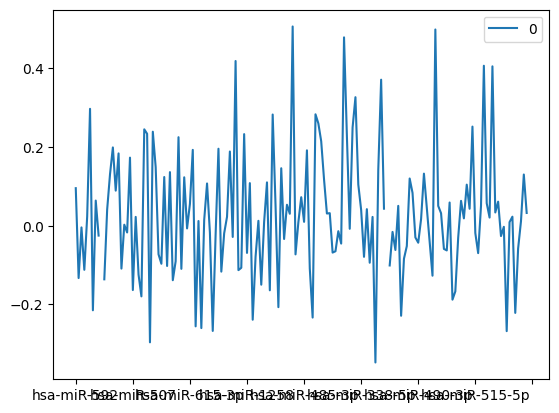

In [39]:
pd.DataFrame(corr).plot()

## TCGA+CCLE mRNA miRNA(miRNA未处理)

In [40]:
mrna = pd.read_csv('/kaggle/input/spatial-transcript-data/ranked_tcga_ccle_mrna.csv',index_col=0)
mirna = pd.read_csv('/kaggle/input/spatial-transcript-data/com_tcga_ccle_mirna.csv',index_col=0)

In [41]:
# 使用 StandardScaler 进行 z-score 标准化
scaler = MinMaxScaler()
mrna_scale = scaler.fit_transform(mrna)

# # 使用 StandardScaler 进行 z-score 标准化
scaler = MinMaxScaler()
mirna_scale = scaler.fit_transform(mirna)

mrna = pd.DataFrame(mrna_scale, columns=mrna.columns)
mirna = pd.DataFrame(mirna_scale, columns=mirna.columns)
x_train, x_test, y_train, y_test = train_test_split(mrna, mirna,test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((969, 1773), (243, 1773), (969, 159), (243, 159))

In [42]:
other_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0, 'reg_alpha': 1, 'reg_lambda': 1}

# 建立XGBoost模型 
model = XGBRegressor(**other_params,tree_method="hist", device="cuda")

t0 = time()
# 训练模型
model.fit(x_train, y_train)
print(f"XGBoost fit done in {(time() - t0):.3f}s")

# 使用模型进行预测
predictions = model.predict(x_test)
r2_score_xgb = r2_score(y_test, predictions)
print(f"XGBoost r^2 on test data : {r2_score_xgb:.3f}")

XGBoost fit done in 62.278s
XGBoost r^2 on test data : 0.314


In [43]:
t0 = time()
lasso = Lasso(alpha=0.5).fit(x_train, y_train)
print(f"Lasso fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso.predict(x_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso r^2 on test data : {r2_score_lasso:.3f}\n")

t0 = time()
enet = ElasticNet(alpha=0.1, l1_ratio=0.1).fit(x_train, y_train)
print(f"ElasticNet fit done in {(time() - t0):.3f}s")

y_pred_enet = enet.predict(x_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(f"ElasticNet r^2 on test data : {r2_score_enet:.3f}")

Lasso fit done in 0.861s
Lasso r^2 on test data : -0.006

ElasticNet fit done in 2.867s
ElasticNet r^2 on test data : 0.139


In [44]:
y_=model.predict(x_train)

In [45]:
metrics_sklearn(y_test,predictions)
metrics_sklearn(y_test,y_pred_lasso)
metrics_sklearn(y_test,y_pred_enet)
metrics_sklearn(y_train,y_)

mse：0.021011
mae：0.095646
r2：0.313989
r2：0.823110

mse：0.028940
mae：0.117302
r2：-0.005709
r2：0.756353

mse：0.024704
mae：0.109169
r2：0.138896
r2：0.792018

mse：0.001867
mae：0.028795
r2：0.923081
r2：0.984059



In [46]:
#保存Model(注:save文件夹要预先建立，否则会报错)
# with open('clf_breast.pickle', 'wb') as f:
#     pickle.dump(model, f)
 # 读取Model
# with open('clf_ccle_bulk.pickle', 'rb') as f:
#     clf = pickle.load(f)
#     #测试读取后的Model
#     predictions = clf.predict(mrna)    

0.9840594228724961


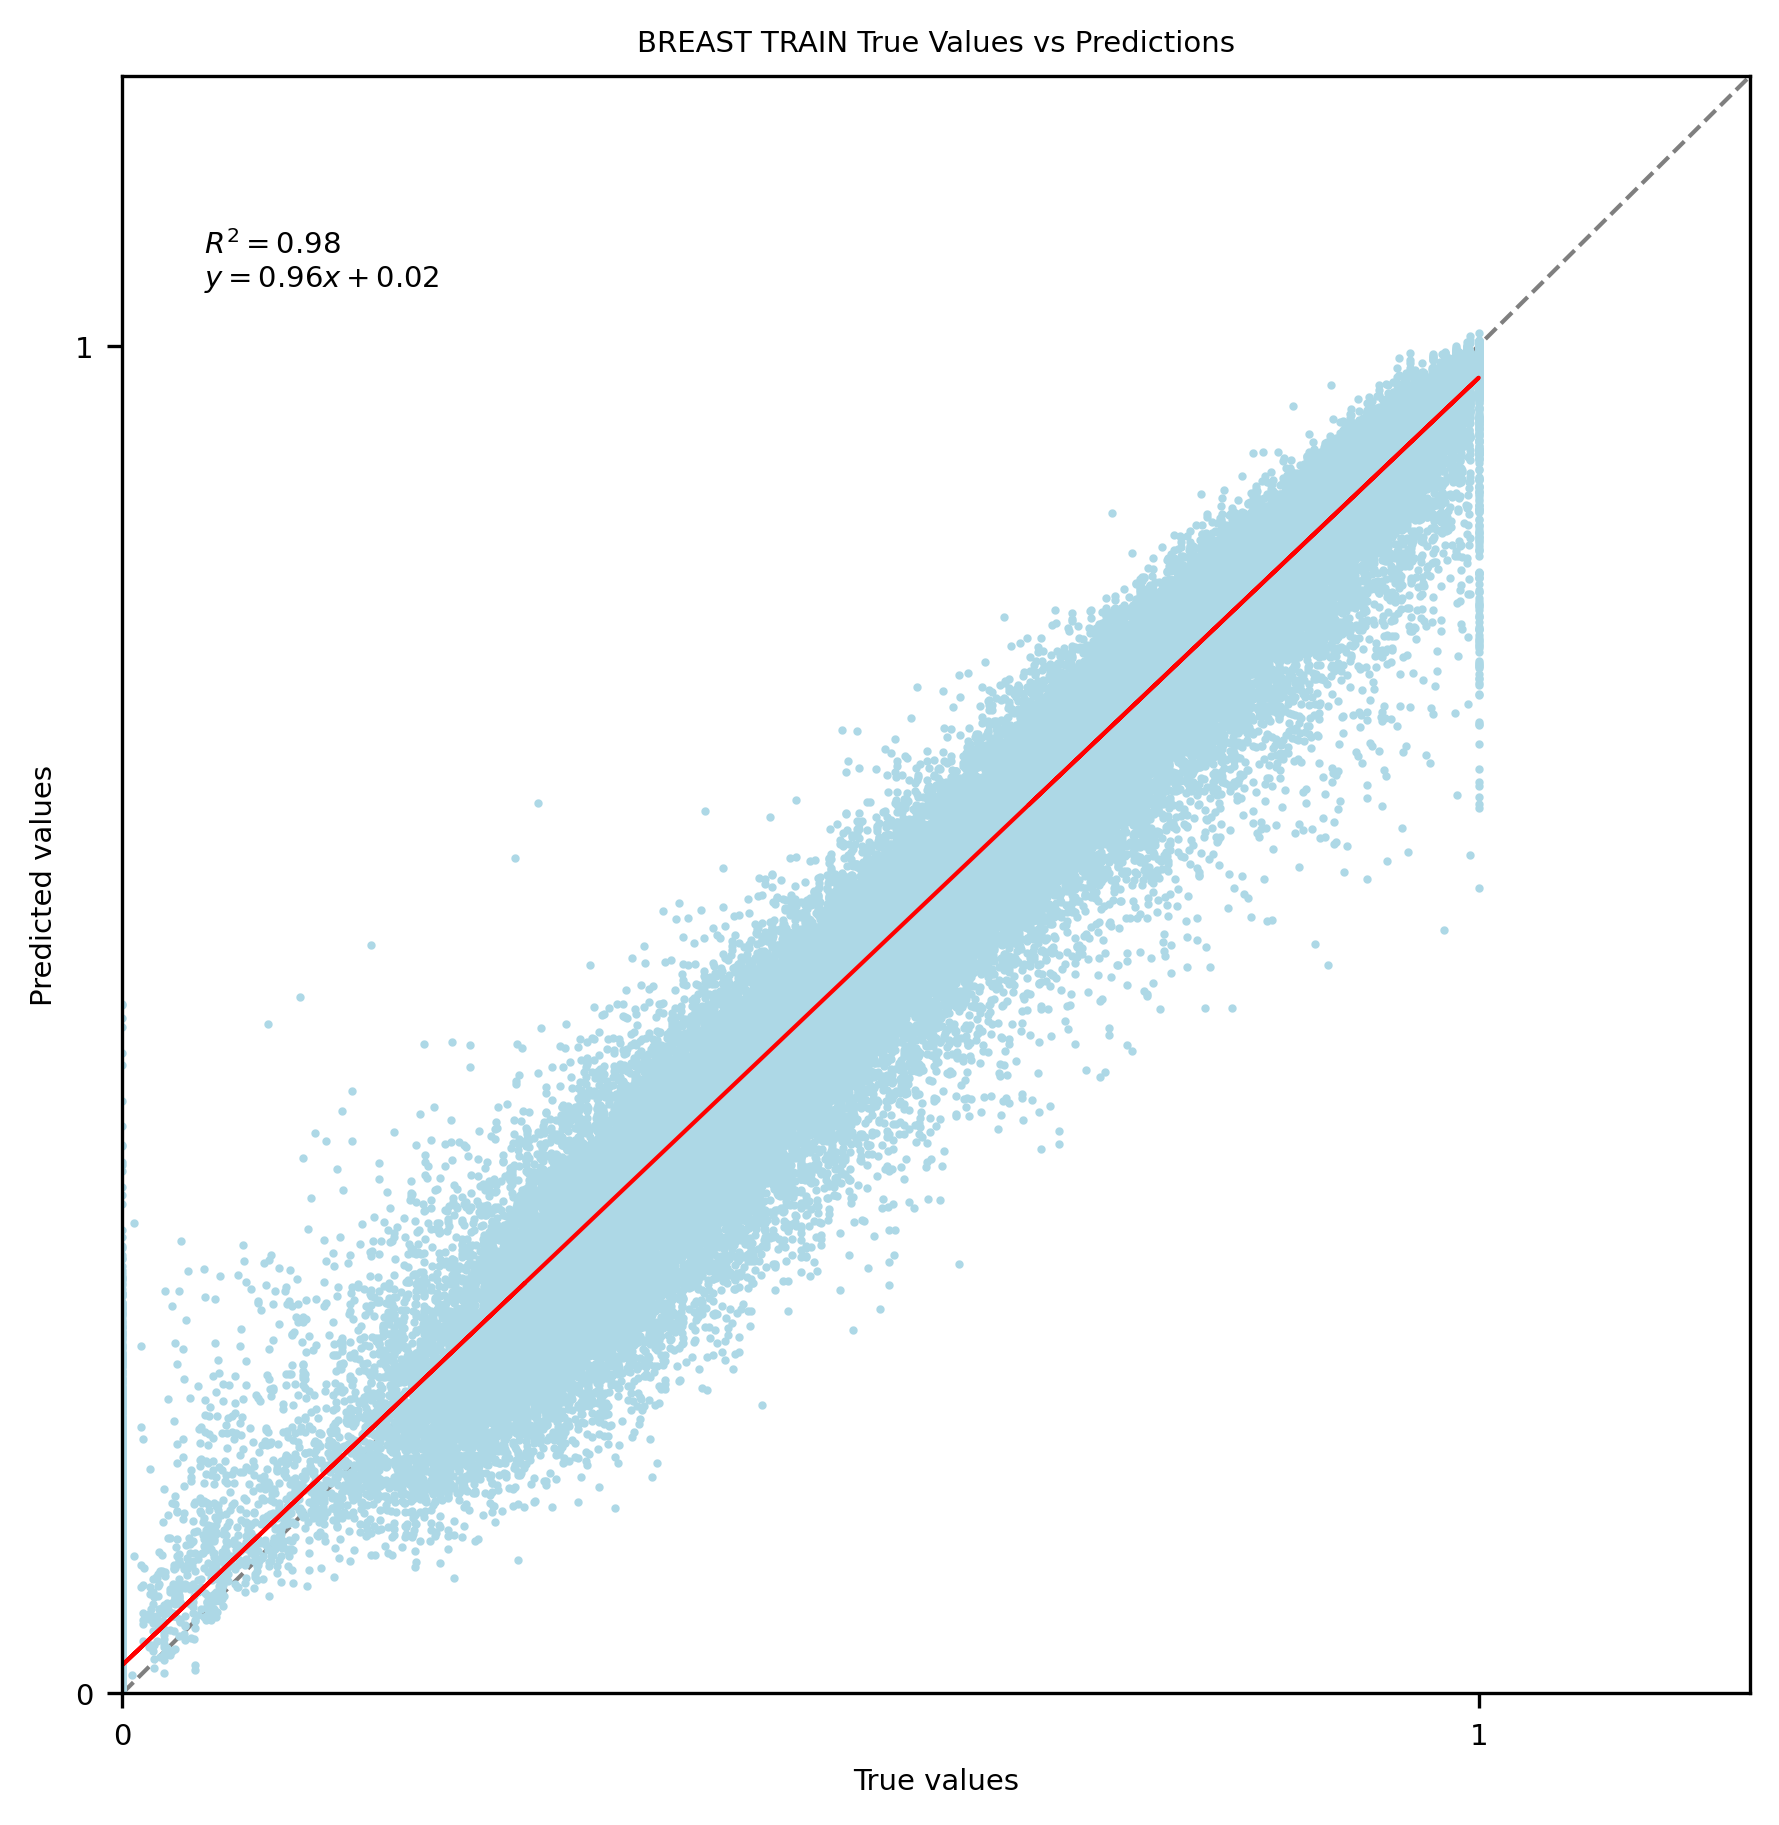

In [47]:
"""
输出观测值和模型预测值之间的拟合曲线,即拟合模型
决定系数R2，有拟合曲线公式，有1:1线
注意：R2、RMSE是预测和实测计算的，即原来的反演或预测模型的值。拟合曲线模型是预测和实测重新计算的拟合曲线。
"""
# x: 是观测值; y: 是模型预测值
x = y_train.values.flatten()
y=y_.flatten()

fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
# 绘制1:1对角线，linewidth线的粗细，ls线的格式，c线的颜色，
ax.plot((0, 1), (0, 1), linewidth=1, transform=ax.transAxes, ls='--', c='k', label="1:1 line", alpha=0.5)
# 绘制点，'o'点的形状，点的颜色，markersize点的大小
ax.plot(x, y, 'o', c='lightblue', markersize=1)

# polyfit(x, y, 1)，1代表线性拟合
# parameter返回的是线性拟合线的斜率和截距
parameter = np.polyfit(x, y, 1)
f = np.poly1d(parameter)
ax.plot(x, f(x), 'r-', lw=1)

# 计算决定系数R
r2 = r2_score(x,y)
print(r2)

# 那个框框的设置
bbox = dict(boxstyle="round", fc='1', alpha=0.)
bbox = bbox
# 在图上安放R2和拟合曲线公式，0.05和0.87是位置偏移量，自己调试
plt.text(0.05, 0.87, "$R^2=%.2f$\n$y=%.2fx+%.2f$" % ((r2), parameter[0], parameter[1]),
         transform=ax.transAxes, size=7, bbox=bbox)

# 横轴的设置
ax.set_xlabel('True values', fontsize=7)
ax.set_ylabel("Predicted values", fontsize=7)

# 设置图片title
ax.tick_params(labelsize=7)
ax.set_title("BREAST TRAIN True Values vs Predictions", fontsize=7)

x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
y_major_locator = MultipleLocator(1)
ax.yaxis.set_major_locator(y_major_locator)
# 坐标轴
ax.set(xlim=(0, 1.2), ylim=(0,1.2))

plt.savefig("BREAST TRAIN True vs Pre.jpg")
plt.show()

0.8231096703167873


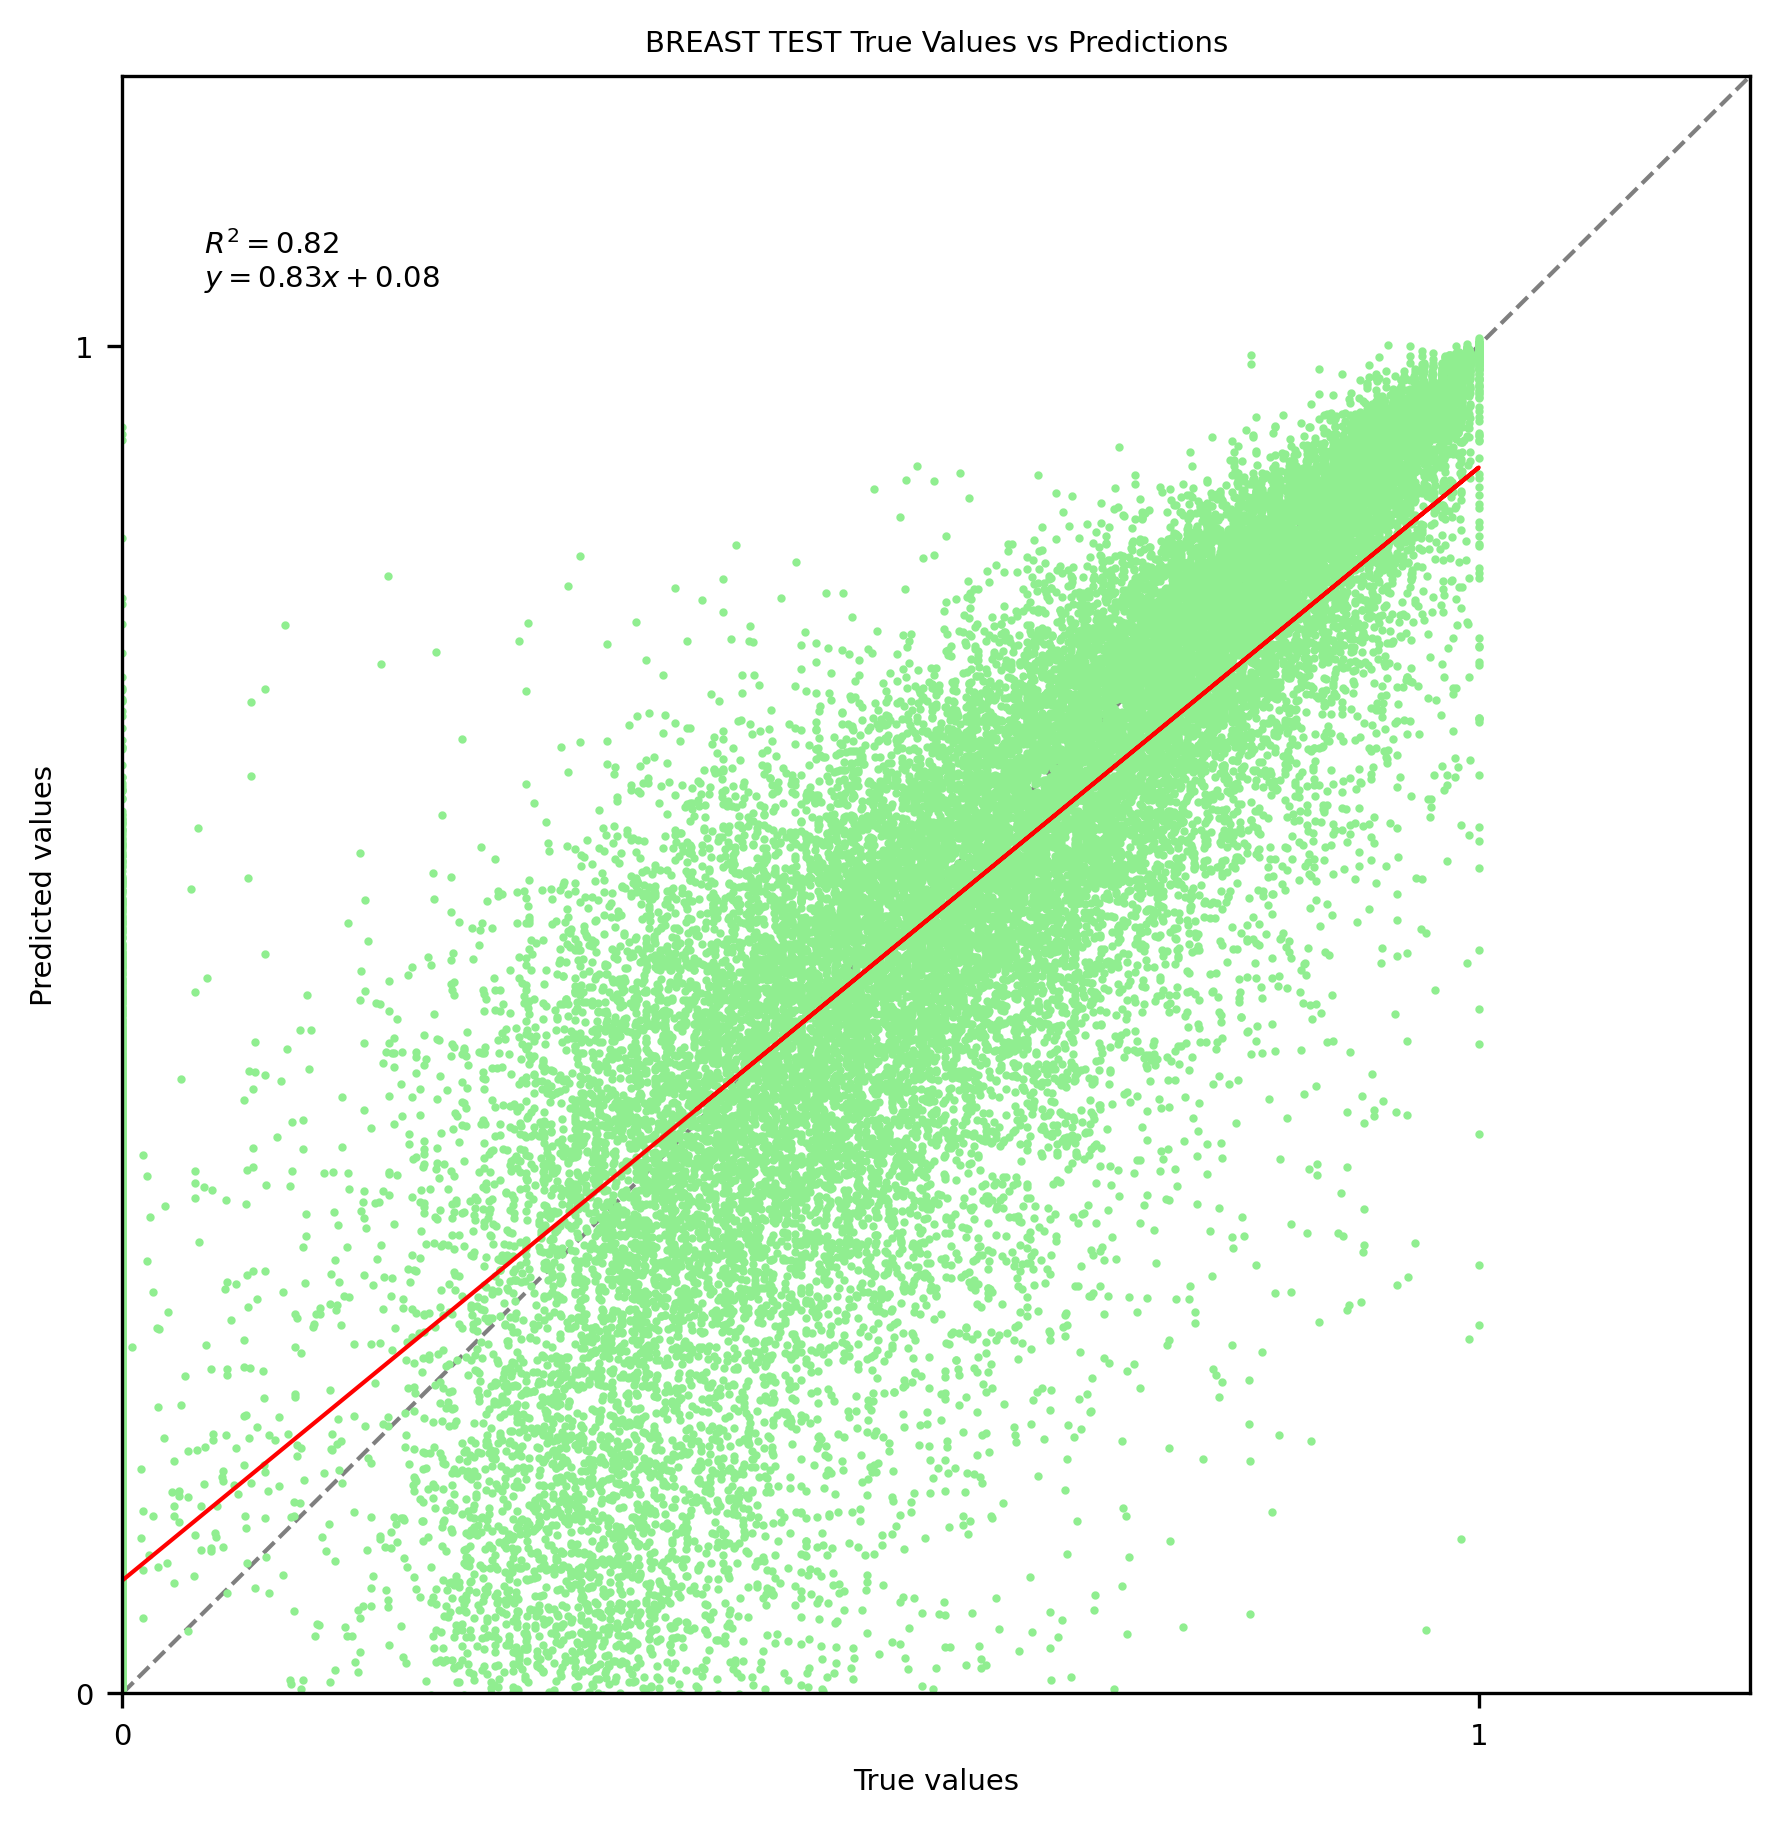

In [48]:
"""
输出观测值和模型预测值之间的拟合曲线,即拟合模型
决定系数R2，有拟合曲线公式，有1:1线
注意：R2、RMSE是预测和实测计算的，即原来的反演或预测模型的值。拟合曲线模型是预测和实测重新计算的拟合曲线。
"""
# x: 是观测值; y: 是模型预测值
x = y_test.values.flatten()
y=predictions.flatten()

fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
# 绘制1:1对角线，linewidth线的粗细，ls线的格式，c线的颜色，
ax.plot((0, 1), (0, 1), linewidth=1, transform=ax.transAxes, ls='--', c='k', label="1:1 line", alpha=0.5)
# 绘制点，'o'点的形状，点的颜色，markersize点的大小
ax.plot(x, y, 'o', c='lightgreen', markersize=1)

# polyfit(x, y, 1)，1代表线性拟合
# parameter返回的是线性拟合线的斜率和截距
parameter = np.polyfit(x, y, 1)
f = np.poly1d(parameter)
ax.plot(x, f(x), 'r-', lw=1)

# 计算决定系数R
r2 = r2_score(x,y)
print(r2)

# 那个框框的设置
bbox = dict(boxstyle="round", fc='1', alpha=0.)
bbox = bbox
# 在图上安放R2和拟合曲线公式，0.05和0.87是位置偏移量，自己调试
plt.text(0.05, 0.87, "$R^2=%.2f$\n$y=%.2fx+%.2f$" % ((r2), parameter[0], parameter[1]),
         transform=ax.transAxes, size=7, bbox=bbox)

# 横轴的设置
ax.set_xlabel('True values', fontsize=7)
ax.set_ylabel("Predicted values", fontsize=7)

# 设置图片title
ax.tick_params(labelsize=7)
ax.set_title("BREAST TEST True Values vs Predictions", fontsize=7)

x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
y_major_locator = MultipleLocator(1)
ax.yaxis.set_major_locator(y_major_locator)
# 坐标轴
ax.set(xlim=(0, 1.2), ylim=(0,1.2))

plt.savefig("BREAST TEST True vs Pre.jpg")
plt.show()

## 预测spatial

In [49]:
st_mrna = pd.read_csv("/kaggle/input/spatial-transcript-data/st_exp.csv",index_col=0)
st_mrna = st_mrna.T
st_mirna = model.predict(st_mrna)
st_mirna = pd.DataFrame(st_mirna,index=st_mrna.index,columns=y_train.columns)
st_mirna.to_csv("Pre-STmirna.csv")

In [50]:
st_mirna

,hsa-miR-767-5p,hsa-miR-199b-5p,hsa-miR-34c-3p,hsa-miR-590-5p,hsa-miR-491-5p,hsa-miR-107,hsa-miR-339-5p,hsa-miR-885-5p,hsa-miR-127-5p,hsa-miR-760,...,hsa-miR-1,hsa-miR-146b-5p,hsa-miR-525-5p,hsa-miR-485-5p,hsa-miR-628-5p,hsa-miR-1323,hsa-miR-342-3p,hsa-miR-140-3p,hsa-miR-520d-3p,hsa-miR-1275
AAACAAGTATCTCCCA-1,0.447806,0.421102,0.390889,0.501049,0.451270,0.454696,0.461321,0.398067,0.452005,0.500912,...,0.479842,0.548074,0.475316,0.481863,0.446194,0.426760,0.554515,0.489358,0.414216,0.476134
AAACACCAATAACTGC-1,0.465373,0.488986,0.413943,0.502659,0.421516,0.405241,0.484907,0.476474,0.429447,0.412144,...,0.480675,0.694282,0.414233,0.460493,0.533761,0.457872,0.506589,0.704433,0.443178,0.455241
AAACAGAGCGACTCCT-1,0.467672,0.503970,0.422986,0.531017,0.460103,0.483494,0.486115,0.404232,0.489404,0.440619,...,0.472723,0.635484,0.525010,0.442563,0.469306,0.450608,0.498562,0.575654,0.441735,0.570335
AAACAGCTTTCAGAAG-1,0.496576,0.520274,0.370975,0.509301,0.439760,0.431314,0.437910,0.365861,0.519353,0.444997,...,0.466076,0.708068,0.522561,0.448819,0.527582,0.459001,0.516114,0.581694,0.505443,0.407720
AAACAGGGTCTATATT-1,0.460989,0.491760,0.419809,0.489627,0.396811,0.493462,0.444761,0.481859,0.514331,0.397949,...,0.475176,0.528376,0.499676,0.458764,0.473957,0.453828,0.522825,0.578613,0.490906,0.441691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.440157,0.447842,0.463290,0.557591,0.379201,0.468569,0.463871,0.398256,0.481778,0.506297,...,0.422440,0.682026,0.533132,0.535456,0.499278,0.437692,0.551082,0.563899,0.496826,0.353657
TTGTTGTGTGTCAAGA-1,0.467971,0.437706,0.423249,0.507082,0.450319,0.513512,0.542190,0.434940,0.509428,0.439503,...,0.463845,0.595141,0.518031,0.492081,0.599724,0.399010,0.524728,0.620368,0.440963,0.454182
TTGTTTCACATCCAGG-1,0.433249,0.456013,0.399234,0.484995,0.448587,0.449876,0.455109,0.558952,0.477266,0.445566,...,0.482854,0.496429,0.482516,0.497149,0.531919,0.390182,0.553621,0.516976,0.468136,0.387448
TTGTTTCATTAGTCTA-1,0.458679,0.487351,0.394453,0.497759,0.433105,0.466941,0.550081,0.441476,0.561706,0.437873,...,0.462548,0.614243,0.487919,0.468087,0.463184,0.445381,0.497552,0.575890,0.449609,0.422586


## TCGA+CCLE mRNA miRNA(miRNA已处理)

In [51]:
mrna = pd.read_csv('/kaggle/input/spatial-transcript-data/ranked_tcga_ccle_mrna.csv',index_col=0)
mirna = pd.read_csv('/kaggle/input/spatial-transcript-data/Procom_tcga_breast_mirna.csv',index_col=0)

In [52]:
# 使用 StandardScaler 进行 z-score 标准化
scaler = MinMaxScaler()
mrna_scale = scaler.fit_transform(mrna)

# # 使用 StandardScaler 进行 z-score 标准化
scaler = MinMaxScaler()
mirna_scale = scaler.fit_transform(mirna)

mrna = pd.DataFrame(mrna_scale, columns=mrna.columns)
mirna = pd.DataFrame(mirna_scale, columns=mirna.columns)
x_train, x_test, y_train, y_test = train_test_split(mrna, mirna,test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((969, 1773), (243, 1773), (969, 346), (243, 346))

In [53]:
other_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0, 'reg_alpha': 1, 'reg_lambda': 1}

# 建立XGBoost模型 
model = XGBRegressor(**other_params,tree_method="hist", device="cuda")

t0 = time()
# 训练模型
model.fit(x_train, y_train)
print(f"XGBoost fit done in {(time() - t0):.3f}s")

# 使用模型进行预测
predictions = model.predict(x_test)
r2_score_xgb = r2_score(y_test, predictions)
print(f"XGBoost r^2 on test data : {r2_score_xgb:.3f}")

XGBoost fit done in 144.753s
XGBoost r^2 on test data : 0.382


In [54]:
t0 = time()
lasso = Lasso(alpha=0.5).fit(x_train, y_train)
print(f"Lasso fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso.predict(x_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso r^2 on test data : {r2_score_lasso:.3f}\n")

t0 = time()
enet = ElasticNet(alpha=0.1, l1_ratio=0.1).fit(x_train, y_train)
print(f"ElasticNet fit done in {(time() - t0):.3f}s")

y_pred_enet = enet.predict(x_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(f"ElasticNet r^2 on test data : {r2_score_enet:.3f}")

Lasso fit done in 1.660s
Lasso r^2 on test data : -0.004

ElasticNet fit done in 4.723s
ElasticNet r^2 on test data : 0.122


In [55]:
y_=model.predict(x_train)

In [56]:
metrics_sklearn(y_test,predictions)
metrics_sklearn(y_test,y_pred_lasso)
metrics_sklearn(y_test,y_pred_enet)
metrics_sklearn(y_train,y_)

mse：0.016387
mae：0.085850
r2：0.381809
r2：0.822654

mse：0.025152
mae：0.110822
r2：-0.004008
r2：0.727789

mse：0.021580
mae：0.103556
r2：0.122314
r2：0.766446

mse：0.001639
mae：0.027348
r2：0.916622
r2：0.982265



0.982265051243376


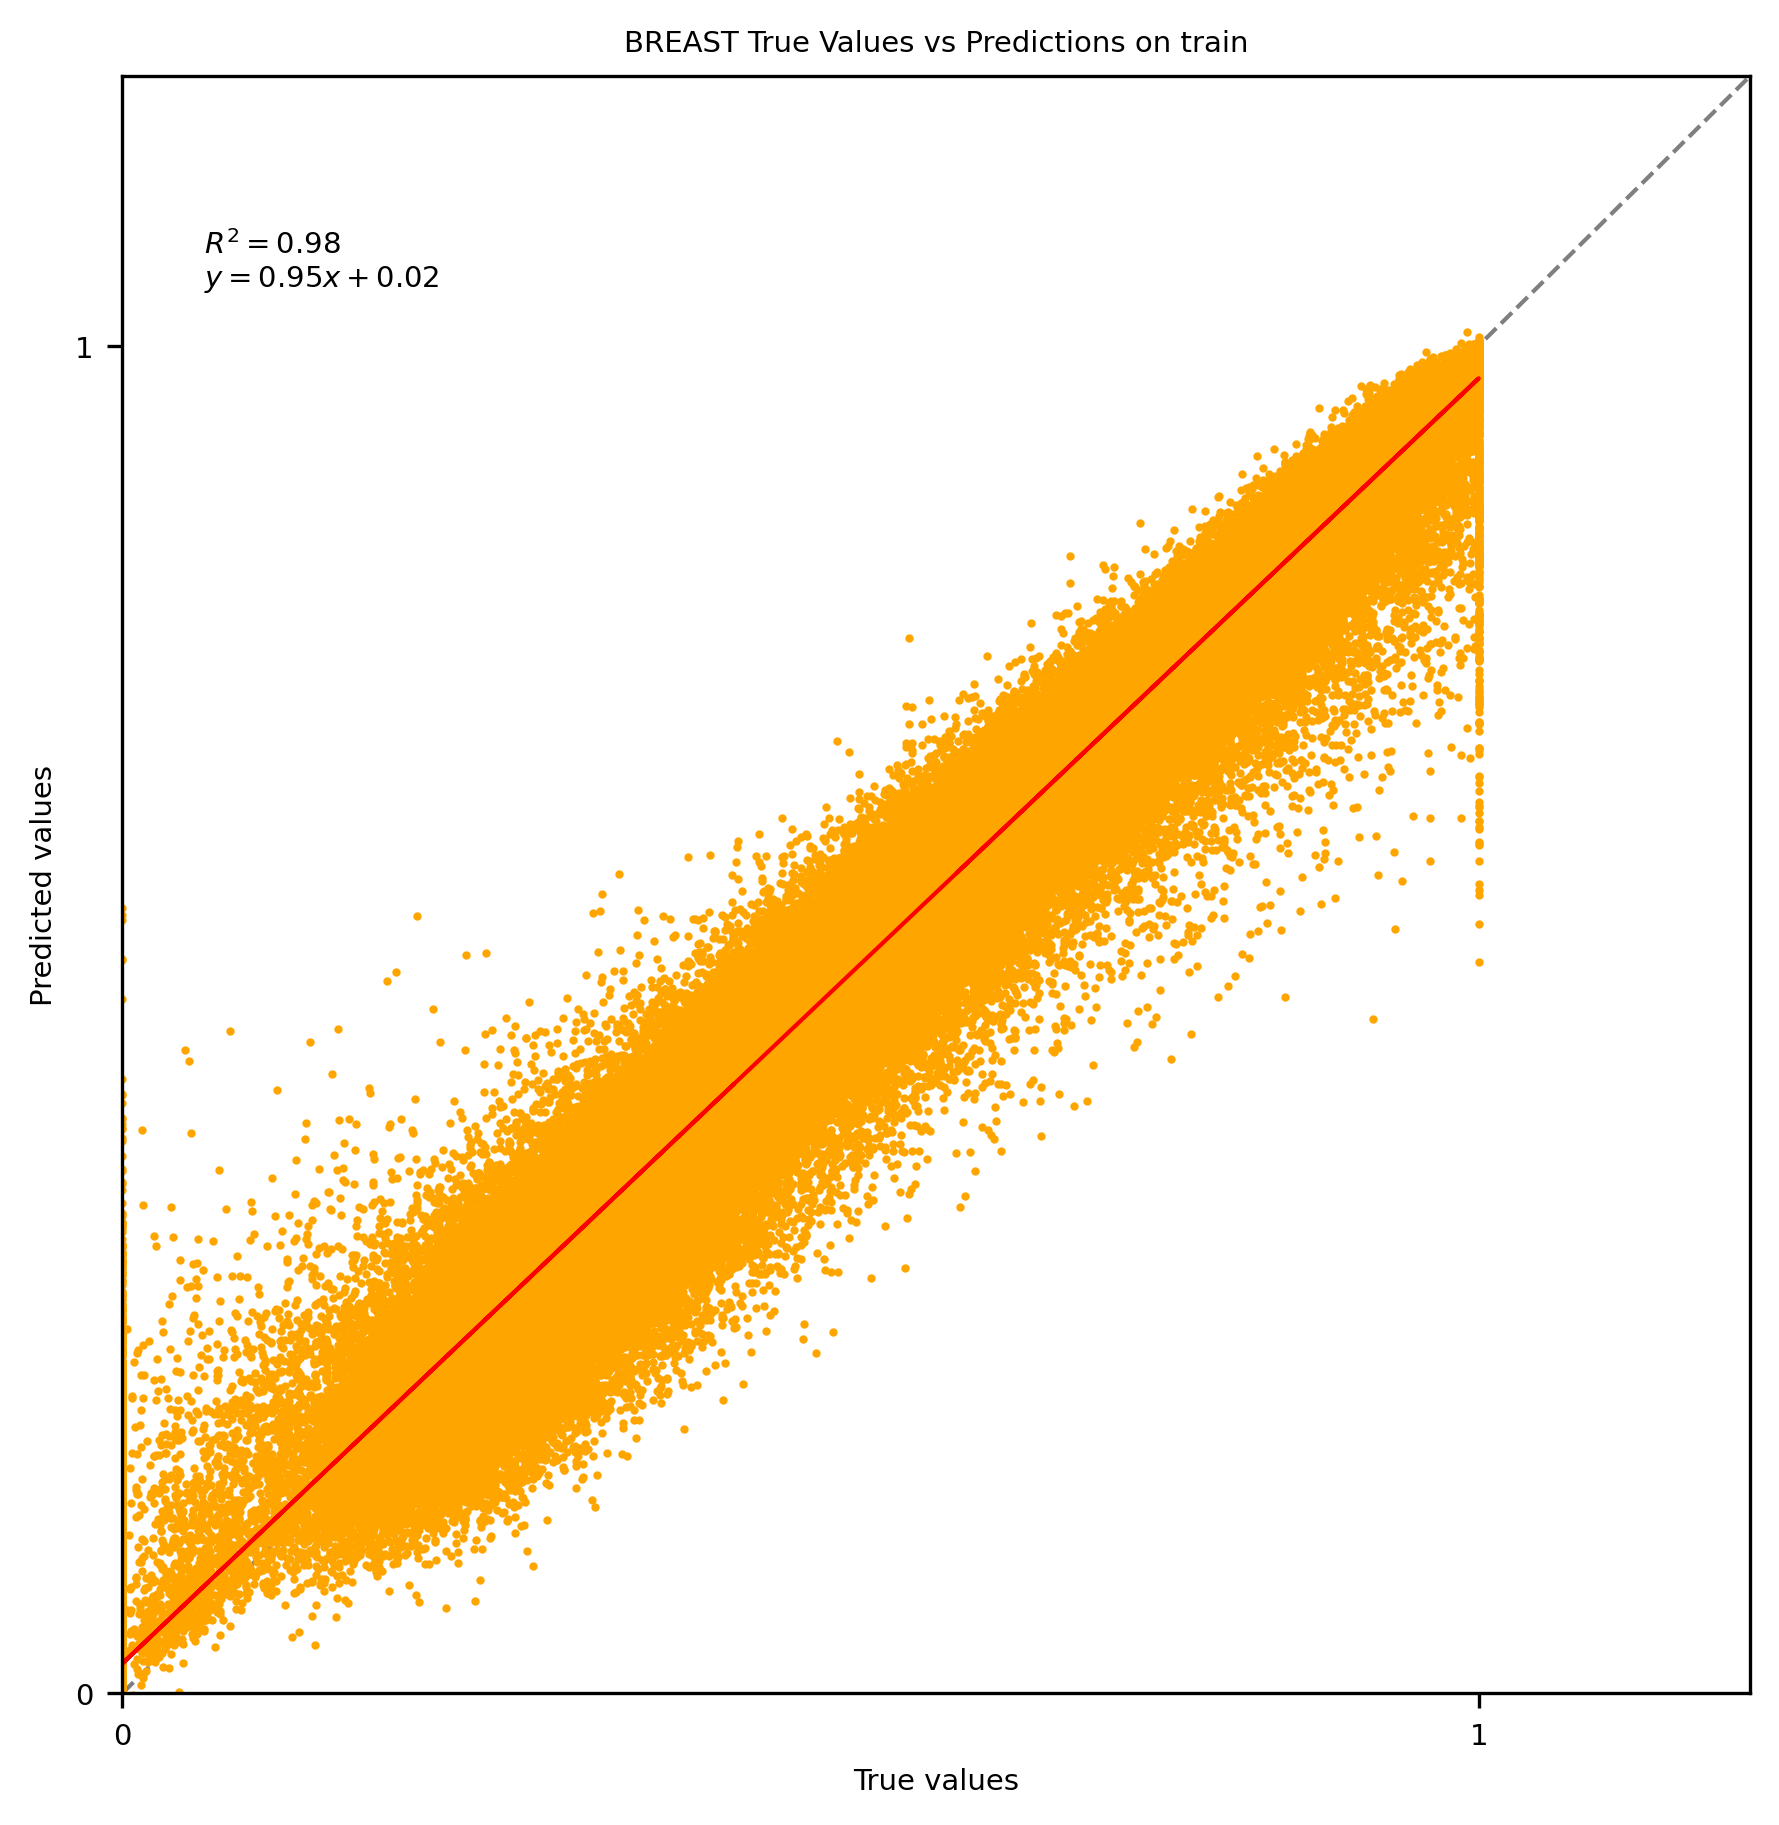

In [57]:
"""
输出观测值和模型预测值之间的拟合曲线,即拟合模型
决定系数R2，有拟合曲线公式，有1:1线
注意：R2、RMSE是预测和实测计算的，即原来的反演或预测模型的值。拟合曲线模型是预测和实测重新计算的拟合曲线。
"""
# x: 是观测值; y: 是模型预测值
x = y_train.values.flatten()
y=y_.flatten()

fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
# 绘制1:1对角线，linewidth线的粗细，ls线的格式，c线的颜色，
ax.plot((0, 1), (0, 1), linewidth=1, transform=ax.transAxes, ls='--', c='k', label="1:1 line", alpha=0.5)
# 绘制点，'o'点的形状，点的颜色，markersize点的大小
ax.plot(x, y, 'o', c='orange', markersize=1)

# polyfit(x, y, 1)，1代表线性拟合
# parameter返回的是线性拟合线的斜率和截距
parameter = np.polyfit(x, y, 1)
f = np.poly1d(parameter)
ax.plot(x, f(x), 'r-', lw=1)

# 计算决定系数R
r2 = r2_score(x,y)
print(r2)

# 那个框框的设置
bbox = dict(boxstyle="round", fc='1', alpha=0.)
bbox = bbox
# 在图上安放R2和拟合曲线公式，0.05和0.87是位置偏移量，自己调试
plt.text(0.05, 0.87, "$R^2=%.2f$\n$y=%.2fx+%.2f$" % ((r2), parameter[0], parameter[1]),
         transform=ax.transAxes, size=7, bbox=bbox)

# 横轴的设置
ax.set_xlabel('True values', fontsize=7)
ax.set_ylabel("Predicted values", fontsize=7)

# 设置图片title
ax.tick_params(labelsize=7)
ax.set_title("BREAST True Values vs Predictions on train", fontsize=7)

x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
y_major_locator = MultipleLocator(1)
ax.yaxis.set_major_locator(y_major_locator)
# 坐标轴
ax.set(xlim=(0, 1.2), ylim=(0,1.2))

plt.savefig("BREAST True vs Pre on train.jpg")
plt.show()

0.8226535953961627


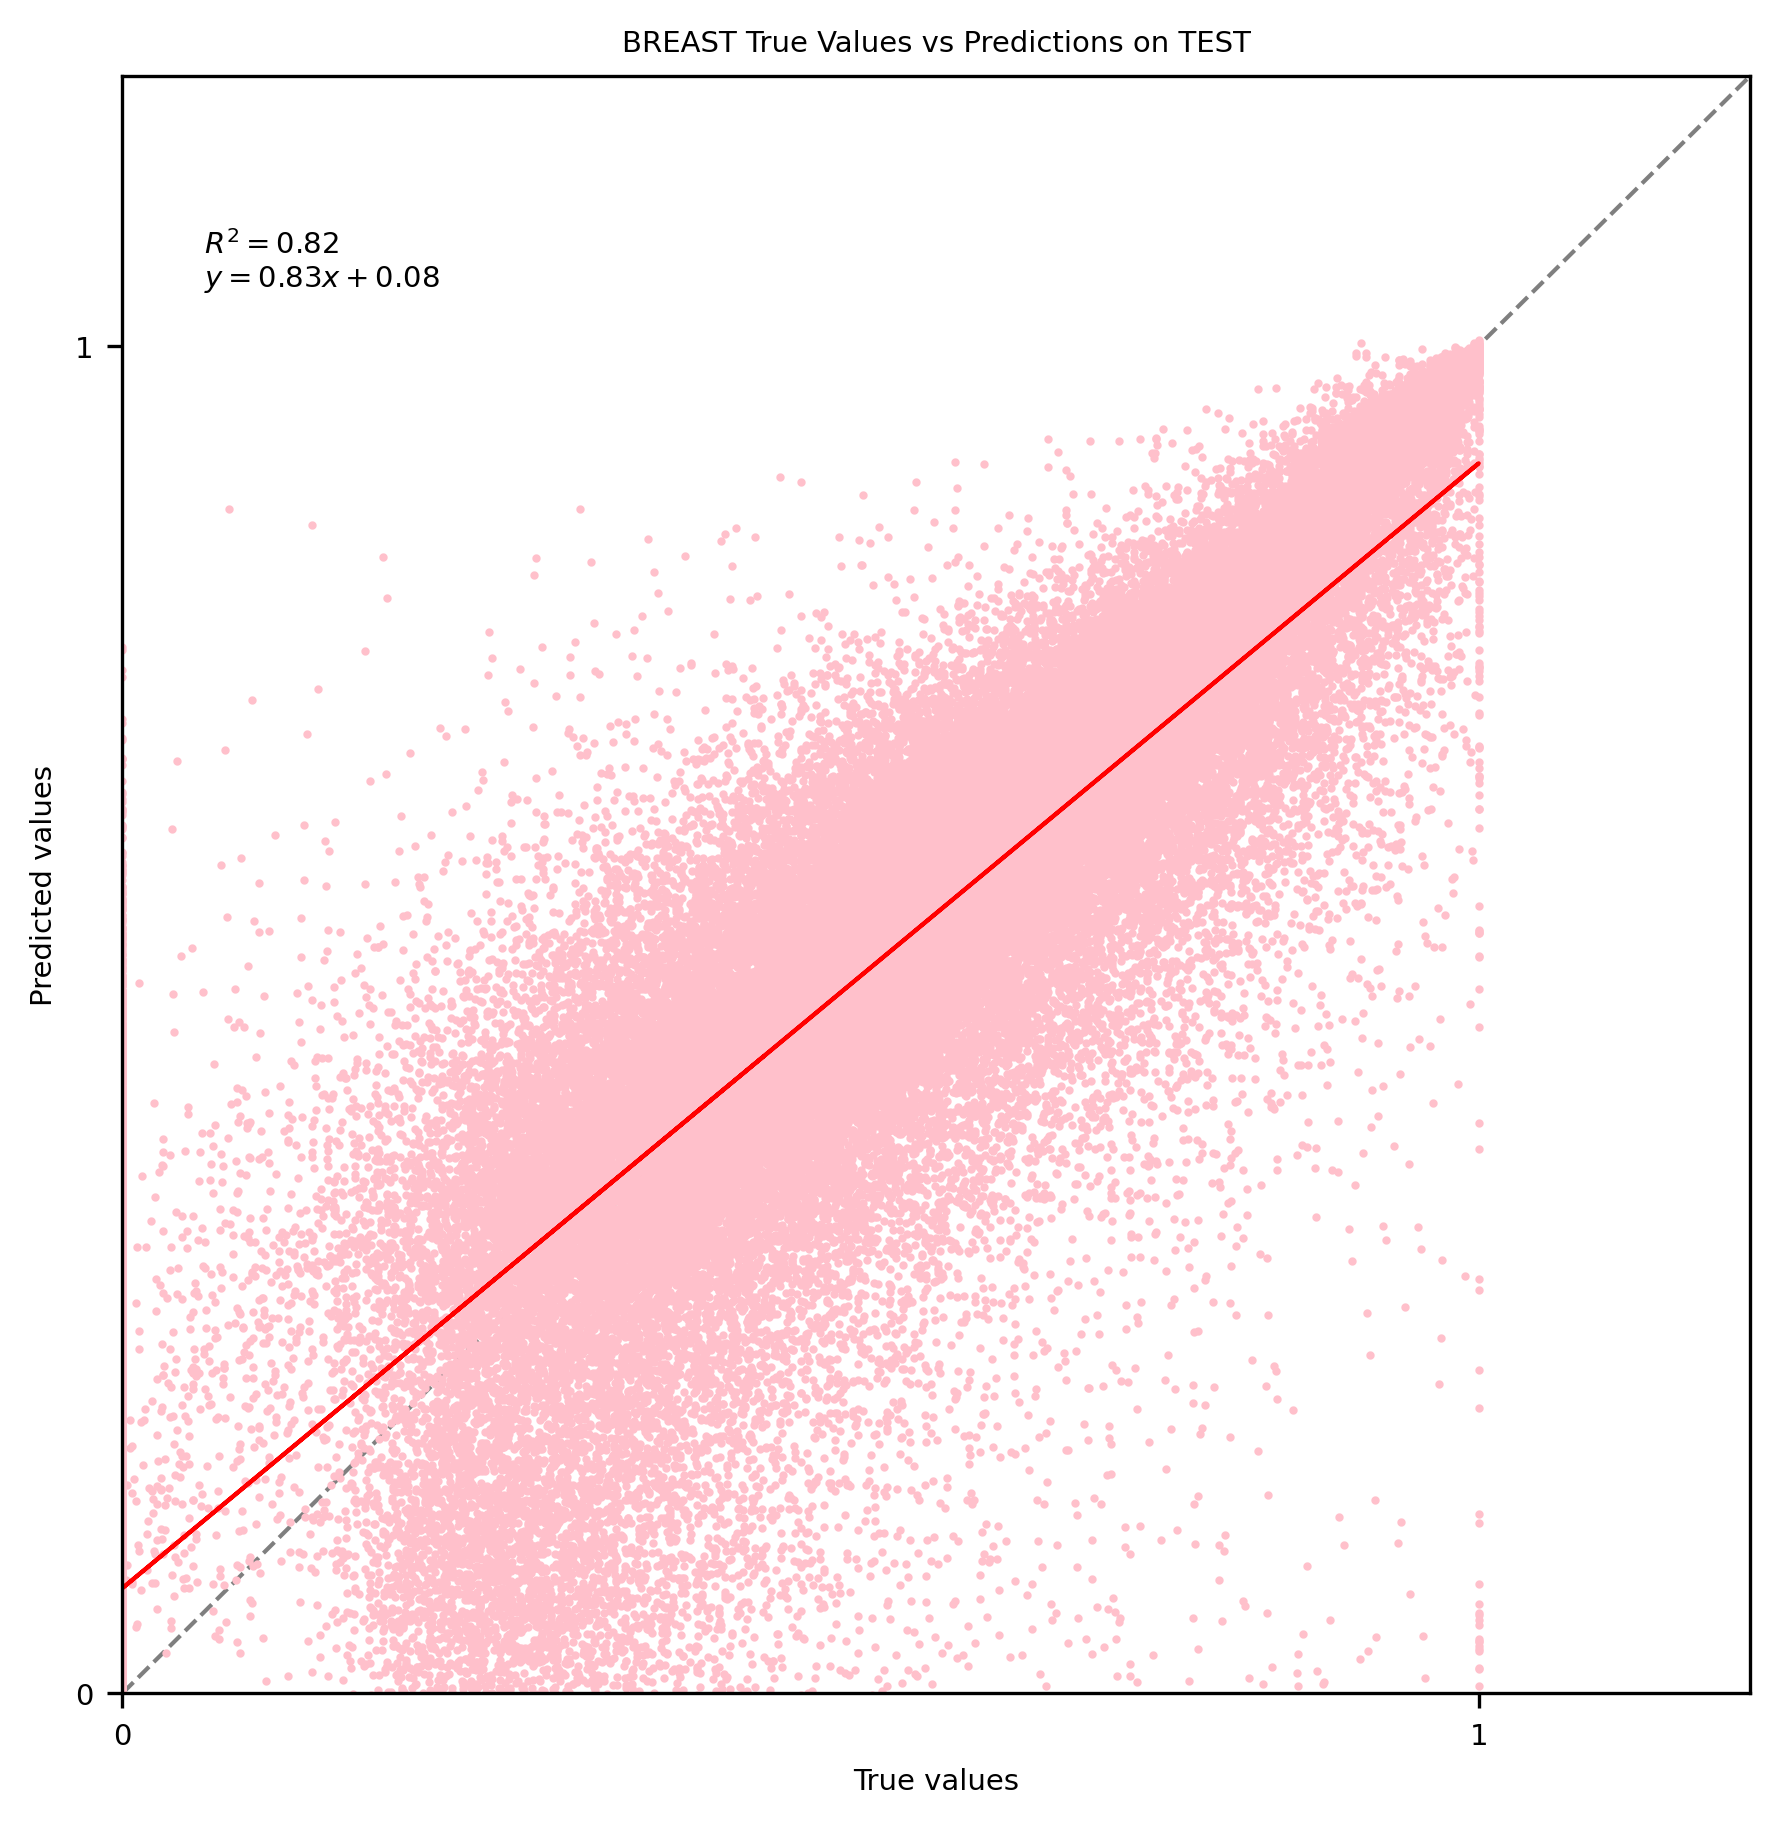

In [58]:
"""
输出观测值和模型预测值之间的拟合曲线,即拟合模型
决定系数R2，有拟合曲线公式，有1:1线
注意：R2、RMSE是预测和实测计算的，即原来的反演或预测模型的值。拟合曲线模型是预测和实测重新计算的拟合曲线。
"""
# x: 是观测值; y: 是模型预测值
x = y_test.values.flatten()
y=predictions.flatten()

fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
# 绘制1:1对角线，linewidth线的粗细，ls线的格式，c线的颜色，
ax.plot((0, 1), (0, 1), linewidth=1, transform=ax.transAxes, ls='--', c='k', label="1:1 line", alpha=0.5)
# 绘制点，'o'点的形状，点的颜色，markersize点的大小
ax.plot(x, y, 'o', c='pink', markersize=1)

# polyfit(x, y, 1)，1代表线性拟合
# parameter返回的是线性拟合线的斜率和截距
parameter = np.polyfit(x, y, 1)
f = np.poly1d(parameter)
ax.plot(x, f(x), 'r-', lw=1)

# 计算决定系数R
r2 = r2_score(x,y)
print(r2)

# 那个框框的设置
bbox = dict(boxstyle="round", fc='1', alpha=0.)
bbox = bbox
# 在图上安放R2和拟合曲线公式，0.05和0.87是位置偏移量，自己调试
plt.text(0.05, 0.87, "$R^2=%.2f$\n$y=%.2fx+%.2f$" % ((r2), parameter[0], parameter[1]),
         transform=ax.transAxes, size=7, bbox=bbox)

# 横轴的设置
ax.set_xlabel('True values', fontsize=7)
ax.set_ylabel("Predicted values", fontsize=7)

# 设置图片title
ax.tick_params(labelsize=7)
ax.set_title("BREAST True Values vs Predictions on TEST", fontsize=7)

x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
y_major_locator = MultipleLocator(1)
ax.yaxis.set_major_locator(y_major_locator)
# 坐标轴
ax.set(xlim=(0, 1.2), ylim=(0,1.2))

plt.savefig("BREAST True vs Pre on TEST.jpg")
plt.show()

## 预测spatial

In [59]:
st_mrna = pd.read_csv("/kaggle/input/spatial-transcript-data/st_exp.csv",index_col=0)
st_mrna = st_mrna.T
st_mirna = model.predict(st_mrna)
st_mirna = pd.DataFrame(st_mirna,index=st_mrna.index,columns=y_train.columns)
st_mirna.to_csv("PrePro-STmirna.csv")

In [60]:
st_mirna

,hsa-miR-107,hsa-miR-1247,hsa-miR-153,hsa-miR-362,hsa-miR-7,hsa-miR-135b,hsa-miR-668,hsa-miR-504,hsa-miR-96,hsa-miR-9,...,hsa-miR-28,hsa-let-7d,hsa-miR-624,hsa-miR-1180,hsa-let-7b,hsa-miR-937,hsa-miR-18b,hsa-miR-202,hsa-miR-485,hsa-miR-491
AAACAAGTATCTCCCA-1,0.451177,0.445092,0.374449,0.487540,0.482695,0.463553,0.472230,0.463917,0.590925,0.551744,...,0.546589,0.485458,0.419920,0.432894,0.487467,0.504207,0.431446,0.389506,0.640679,0.461996
AAACACCAATAACTGC-1,0.484321,0.528569,0.434430,0.494451,0.457739,0.473036,0.523979,0.425361,0.576121,0.489782,...,0.694603,0.494257,0.384582,0.475002,0.484332,0.469934,0.472801,0.445175,0.486388,0.457152
AAACAGAGCGACTCCT-1,0.477707,0.510145,0.354434,0.506663,0.426925,0.489255,0.464186,0.456960,0.572252,0.560292,...,0.604012,0.470338,0.382942,0.475573,0.486558,0.461159,0.483729,0.429696,0.663795,0.473149
AAACAGCTTTCAGAAG-1,0.475199,0.525731,0.469674,0.484432,0.471659,0.427508,0.488328,0.442977,0.552982,0.510752,...,0.766612,0.502934,0.444205,0.460751,0.510975,0.460440,0.523661,0.387028,0.531668,0.493307
AAACAGGGTCTATATT-1,0.478980,0.523282,0.368043,0.489532,0.474989,0.448588,0.535230,0.525086,0.602786,0.547802,...,0.636524,0.480791,0.325086,0.497413,0.505564,0.480908,0.524823,0.408556,0.515329,0.467622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.466164,0.503900,0.409155,0.479900,0.432515,0.432366,0.472191,0.493628,0.637354,0.534371,...,0.541193,0.490630,0.422767,0.440062,0.472220,0.464083,0.504380,0.395228,0.561083,0.451190
TTGTTGTGTGTCAAGA-1,0.477729,0.483345,0.360824,0.503262,0.422855,0.445620,0.439061,0.439633,0.597958,0.551592,...,0.550384,0.499919,0.435098,0.491455,0.496639,0.439660,0.485302,0.398528,0.554639,0.482638
TTGTTTCACATCCAGG-1,0.478658,0.504648,0.420293,0.469978,0.459968,0.473188,0.470307,0.451896,0.617841,0.500927,...,0.651239,0.477293,0.380526,0.485165,0.493156,0.493402,0.472000,0.406658,0.532766,0.462180
TTGTTTCATTAGTCTA-1,0.463266,0.460829,0.474644,0.474933,0.462892,0.444804,0.518036,0.436598,0.605096,0.511568,...,0.682043,0.460864,0.456854,0.499154,0.468136,0.437383,0.521997,0.378666,0.455449,0.451200
